In [1]:
from IPython.display import Image

# Постановка задачи

## Определение проблемы и составление стратегии решения

Цель работы - создать работающую модель прогнозирования продаж для магазинов Спортмастер на примере продаж 1 модели велосипедов.


Почему это важно для велосипедов -
1. велосипеды являются крупногабаритным товаров, своевременный привоз которых в магазины важен во избежание затоваривания склада магазинов, оптимизации работы сборщиков и чтобы избежать нехватки товаров, либо, наоборот излишка (и проблем, связанных с его возвратом на центральный склад ит.д.)

2. В СМ есть сборочные предприятия, ресурс которых также ограничен и есть необходимость правильно распределить работу, чтобы завод не простаивал - т.к. это убытки для СМ.

Для решения задачи будем использовать три различные методологии:
    1. классические методы анализа временных рядов
    2. Нейронные сети
    3. классические методы ML

## Целевые метрики: пояснить, как будете измерять качество
модели, почему выбрали такие метрики, перечислить
особенности и недостатки, на которые нужно обратить
внимание. Метрики должны отражать характеристики задачи
и предметной области. Обязательно нужны их формулы.

Основная проблем в том, что, для методов ML, которые планируется использовать в работе, нет единой метрики - классические методы анализа временных рядов используют критерий Акаике, в keras будем использовать rmse/mse, в классических методах ML будем использовать также rmse/mse. затем, для проведения финального сравнения эффективности работы приведем все ошибки к единому критерию - MAPE. Этот показатель удобен для оценки со стороны руководства, не погруженного в тему




# Анализ

## Предварительный анализ данных: исходные данные

Данных, которые удалось получить, не так много, чтобы проводить их подробный анализ - это объем продаж понедельно по 1 модели велосипеда.
Дополнительныйх данных, таких как тип магазина, населенный пункт, время продажи, праздники и т.д. - на этом этапе получить не удалось.

Основная задача сейчас - доказать, что это прогнозирование возможно, а затем детализировать прозноз

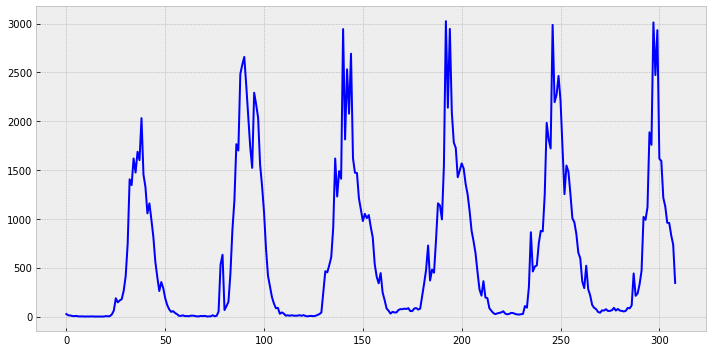

In [2]:
Image(filename='def_graph.png') 

## Алгоритмы и техники

В работе произведен расчет с помощью трех различных методик

### Классические методы анализа временных рядов

Т.к. рынок велосипедов в РФ - с ярко выраженной сезонностью, а методы классического анализа временных рядов отлично учитывают этот фактор. в работе планирую использовать сразу продвинутый метод прогнозирования SARIMA, минуя MA и т.д.

### Нейронные сети

Нейронные сети в н.в. стали наиболее быстро развивающимся сегментом ML, поэтому применение их в работе более чем обоснованно

### Классические методы ML

классические методы ML, такие как xbgoost и decision trees так же применяются при решении задач прогнозирования значений временных рядов. 

# Методика решения

## Классические алгоритмы анализа временных рядов

### Импорты

In [3]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import datetime
from dateutil.relativedelta import relativedelta

from arch import arch_model

p = print

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
%matplotlib inline

In [5]:
df = pd.read_csv('raw_data_fin.csv', delimiter = ';')

### вывод таблицы

In [6]:
df.head()

,date,Sales
0,09.09.2012,25
1,16.09.2012,12
2,23.09.2012,11
3,30.09.2012,5
4,07.10.2012,4


In [7]:
df.columns = ['date','sales']

### функции графиков рядов

In [8]:
def tsplot(y, win, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    rolmean = y.rolling(window=win).mean()
    rolstd = pd.rolling_std(y, window=win)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        rolmean.plot(ax=ts_ax, color='red')
        rolstd.plot(ax=ts_ax, color='black')
        ts_ax.set_title('Original(blue), Rolling Mean(red) & Standard Deviation(black)')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')

        plt.tight_layout()
    return

In [9]:
def seasonal_decompose_plot(y,  freq=None):
    if not isinstance(y, pd.Series): 
        y = pd.Series(y) 

    decomposition = seasonal_decompose(Y, freq=freq)
    # fig = plt.figure()
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    return

In [10]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dftest[0] > dftest[4]['5%']:
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

### Предобработка данных: описать шаги по очистке и
преобразованию данных, способ их хранения и
представления для работы модели. Привести ссылку на
iPython-ноутбук или его раздел с соответствующим кодом.

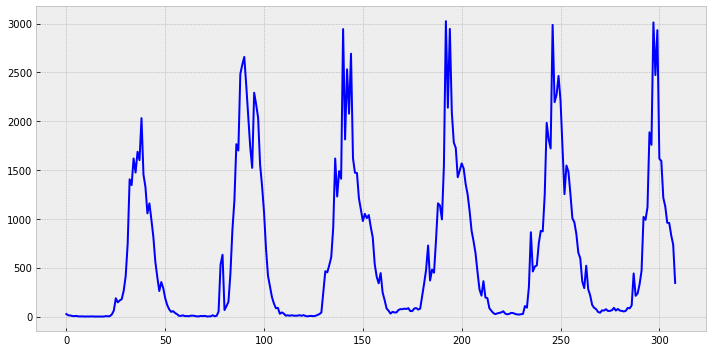

In [11]:
Image(filename='def_graph.png') 

### преобразуем даты в формат datetime

In [12]:
df.index.name=None
df.reset_index(inplace=True)

In [13]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [14]:
df.head()

,date,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


### рисуем графики ряда, AR, APR

сезон - 52 недели. но т.к. по факту, присутствуют два явных паттерна - полный ноль и продажи, используем так же и 26 недель

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=52,center=False).std()
  """


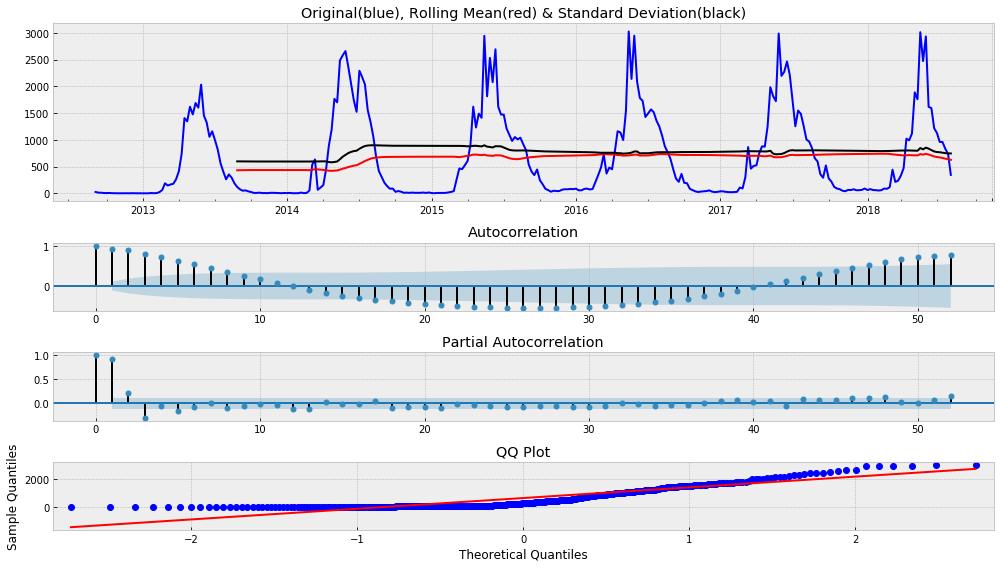

In [196]:
tsplot(df.sales, win=52, lags=52)
plt.savefig('tsplot52.png', bbox_inches='tight')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=26,center=False).std()
  """


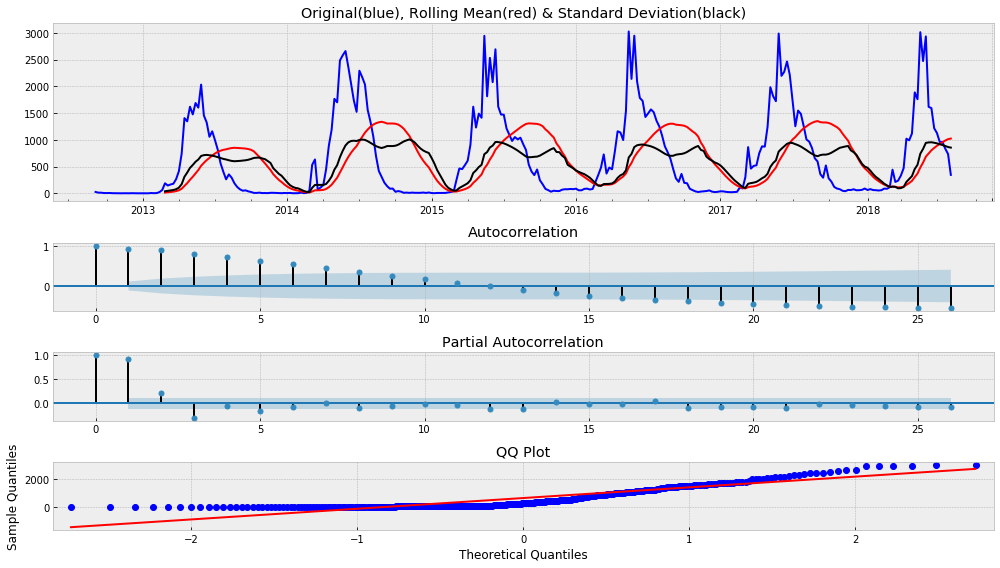

In [16]:
tsplot(df.sales, win=26, lags=26)

декомпозицию также построили по двум периодам, видим, что остатки при 52 все же менее системные

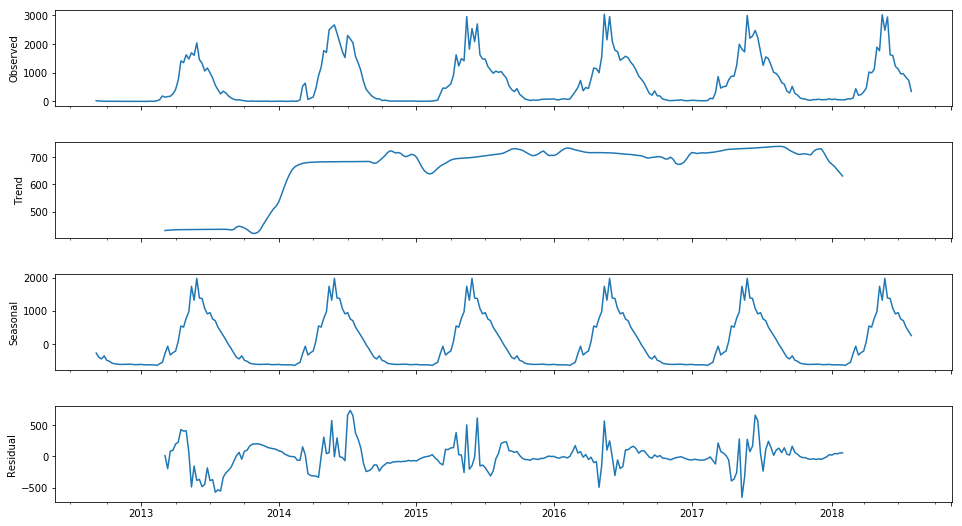

In [17]:
decomposition = seasonal_decompose(df.sales, freq=52)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

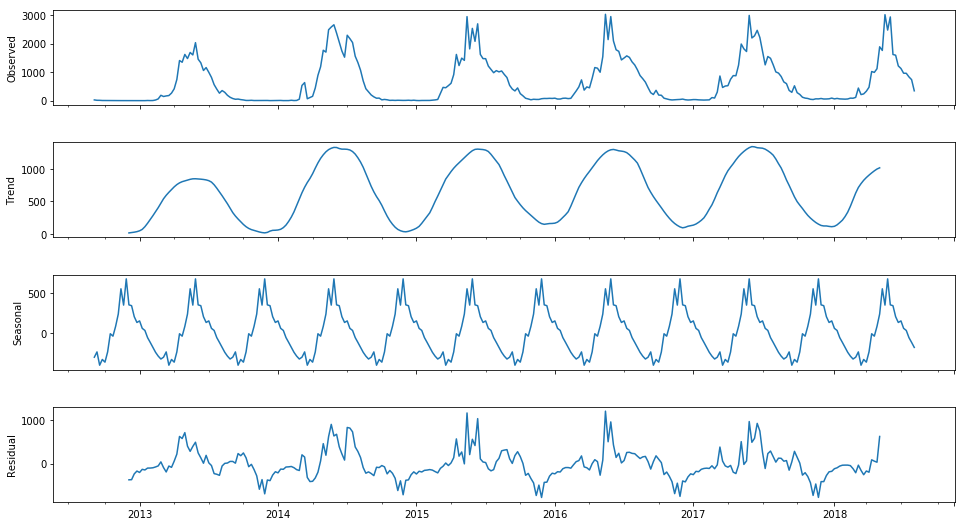

In [18]:
decomposition = seasonal_decompose(df.sales, freq=26)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

### проверка на стационарность

In [19]:
test_stationarity(df.sales)

Results of Dickey-Fuller Test:
Test Statistic                -5.770617e+00
p-value                        5.403200e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.960000e+02
Critical Value (1%)           -3.452637e+00
Critical Value (5%)           -2.871354e+00
Critical Value (10%)          -2.571999e+00
dtype: float64
ряд стационарен


### SARIMA

Подбор параметров SARIMAX осуществлялся вручную, без оптимизации гиперпараметров. Указанные параметры показали наиболее приемлемый результат среди около 20-30 наборов

In [160]:
mod = sm.tsa.statespace.SARIMAX(df.sales, order=(10,0,3), seasonal_order=(0,0,0,26), trend = 'n')
results = mod.fit()
p(results.summary())

C:\Pythonn\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                  309
Model:              SARIMAX(10, 0, 3)   Log Likelihood               -2169.700
Date:                Thu, 11 Oct 2018   AIC                           4367.400
Time:                        00:53:25   BIC                           4419.666
Sample:                    09-09-2012   HQIC                          4388.296
                         - 08-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6208      0.708      0.876      0.381      -0.767       2.009
ar.L2         -0.1408      0.149     -0.948      0.343      -0.432       0.150
ar.L3          0.8493      0.089      9.516      0.0

### Прогноз

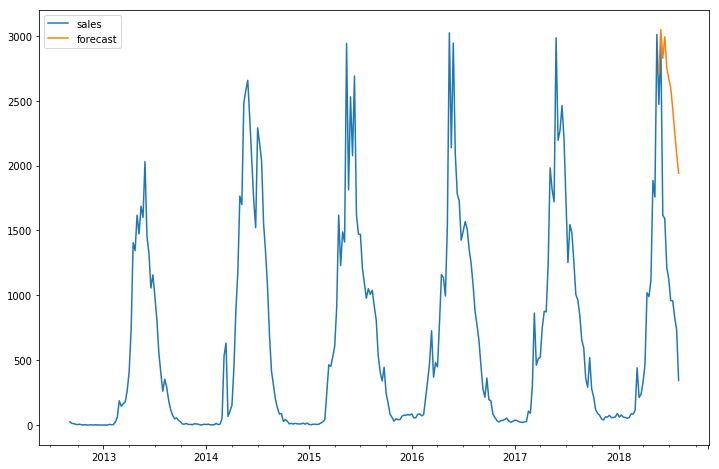

In [194]:
df['forecast'] = results.predict(start = 298, end= 309, dynamic= True)
df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [215]:
mape(Y_test, df.forecast[298:] )

1.4426760239489413

### Выводы

Как мы видим, даже учитывая ярко выраженную сезонность продаж, модель Sarima показала достаточно посредственный результат на интервале в 2 месяца (впрочем, на интервале 4-5 недель ошибка минимальна), сравним ее с другими методами ML

## Нейронная сеть. Классический метод

В нейронных сетях анализ проводился двумя разными способами, классический способ и способ с использованием кросс-валидации на сетях с 1-й эпохой

### Импорты

In [36]:
import pandas as pd


import numpy as np
import matplotlib.pyplot as plt

import keras

import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"

C:\Pythonn\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Pythonn\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor

In [37]:
import copy

In [38]:
df = pd.read_csv('raw_data_fin.csv', delimiter= ';')

In [39]:
df.head()

,date,Sales
0,09.09.2012,25
1,16.09.2012,12
2,23.09.2012,11
3,30.09.2012,5
4,07.10.2012,4


In [40]:
df.columns = ['data','sales']

In [41]:
df.index.name=None
df.reset_index(inplace=True)

In [42]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(df.sales))]
df['index'] =date_list
df.set_index(['index'], inplace=True)
df.index.name=None

In [43]:
df.head()

,data,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


In [44]:
data = copy.deepcopy(df['sales'])

In [45]:
data.head()

2012-09-09    25
2012-09-16    12
2012-09-23    11
2012-09-30     5
2012-10-07     4
Name: sales, dtype: int64

### написание функций для разбивки на train/test

Т.к. объем данных у нас небольшой, для искусственного увеличения последовательностей разобъем данные на отрезки по 26 недель (за основу возьмем финальный используемый в sarima интервал - полгода). использование 52 недель ухудшало точность в среднем на 10%

In [46]:
def  shuffle_in_unison (a, b):

    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [47]:
WINDOW = 26
STEP = 1
FORECAST = 11


X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        y = []

    except Exception as e:
        print (e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

index out of bounds


### Построение модели

Модель регрессии строилась в несколько итераций с последовательным усложнением - для последовательного улучшения и понимания какие методики работают, а какие - ухудшают качество

#### модель 1, сигмоид в функции активации

Используем линейную функцию активации на выходе и сигмоид в первом слое

In [48]:
model = Sequential()
model.add(Dense(64, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [49]:
opt = Nadam(lr=0.0001)

In [50]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [51]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/350
 - 0s - loss: 1035990.5392 - mean_squared_error: 1035990.5392 - val_loss: 1618622.3996 - val_mean_squared_error: 1618622.3996
Epoch 2/350
 - 0s - loss: 1035874.8507 - mean_squared_error: 1035874.8507 - val_loss: 1618439.7824 - val_mean_squared_error: 1618439.7824
Epoch 3/350
 - 0s - loss: 1035748.8755 - mean_squared_error: 1035748.8755 - val_loss: 1618259.8951 - val_mean_squared_error: 1618259.8951
Epoch 4/350
 - 0s - loss: 1035627.6729 - mean_squared_error: 1035627.6729 - val_loss: 1618082.0759 - val_mean_squared_error: 1618082.0759
Epoch 5/350
 - 0s - loss: 1035505.2998 - mean_squared_error: 1035505.2998 - val_loss: 1617905.7210 - val_mean_squared_error: 1617905.7210
Epoch 6/350
 - 0s - loss: 1035380.5848 - mean_squared_error: 1035380.5848 - val_loss: 1617726.6652 - val_mean_squared_error: 1617726.6652
Epoch 7/350
 - 0s - loss: 1035258.6536 - mean_squared_error: 1035258.6536 - val_loss: 1617540.1105 - val_mean_squared_error: 16

Epoch 60/350
 - 0s - loss: 1028027.9280 - mean_squared_error: 1028027.9280 - val_loss: 1607001.7734 - val_mean_squared_error: 1607001.7734
Epoch 61/350
 - 0s - loss: 1027889.9940 - mean_squared_error: 1027889.9940 - val_loss: 1606791.2958 - val_mean_squared_error: 1606791.2958
Epoch 62/350
 - 0s - loss: 1027746.6237 - mean_squared_error: 1027746.6237 - val_loss: 1606575.5725 - val_mean_squared_error: 1606575.5725
Epoch 63/350
 - 0s - loss: 1027602.0265 - mean_squared_error: 1027602.0265 - val_loss: 1606364.2176 - val_mean_squared_error: 1606364.2176
Epoch 64/350
 - 0s - loss: 1027459.1808 - mean_squared_error: 1027459.1808 - val_loss: 1606152.8114 - val_mean_squared_error: 1606152.8114
Epoch 65/350
 - 0s - loss: 1027313.8294 - mean_squared_error: 1027313.8294 - val_loss: 1605945.3504 - val_mean_squared_error: 1605945.3504
Epoch 66/350
 - 0s - loss: 1027173.4733 - mean_squared_error: 1027173.4733 - val_loss: 1605742.3292 - val_mean_squared_error: 1605742.3292
Epoch 67/350
 - 0s - loss: 

Epoch 119/350
 - 0s - loss: 1019726.4096 - mean_squared_error: 1019726.4096 - val_loss: 1594741.4688 - val_mean_squared_error: 1594741.4688
Epoch 120/350
 - 0s - loss: 1019585.4401 - mean_squared_error: 1019585.4401 - val_loss: 1594530.9386 - val_mean_squared_error: 1594530.9386
Epoch 121/350
 - 0s - loss: 1019443.6388 - mean_squared_error: 1019443.6388 - val_loss: 1594316.4051 - val_mean_squared_error: 1594316.4051
Epoch 122/350
 - 0s - loss: 1019297.5871 - mean_squared_error: 1019297.5871 - val_loss: 1594103.0067 - val_mean_squared_error: 1594103.0067
Epoch 123/350
 - 0s - loss: 1019154.6095 - mean_squared_error: 1019154.6095 - val_loss: 1593887.9665 - val_mean_squared_error: 1593887.9665
Epoch 124/350
 - 0s - loss: 1019015.0686 - mean_squared_error: 1019015.0686 - val_loss: 1593683.4040 - val_mean_squared_error: 1593683.4040
Epoch 125/350
 - 0s - loss: 1018878.2354 - mean_squared_error: 1018878.2354 - val_loss: 1593483.1641 - val_mean_squared_error: 1593483.1641
Epoch 126/350
 - 0s 

Epoch 178/350
 - 0s - loss: 1011511.0901 - mean_squared_error: 1011511.0901 - val_loss: 1582487.6417 - val_mean_squared_error: 1582487.6417
Epoch 179/350
 - 0s - loss: 1011373.5808 - mean_squared_error: 1011373.5808 - val_loss: 1582278.9676 - val_mean_squared_error: 1582278.9676
Epoch 180/350
 - 0s - loss: 1011232.7947 - mean_squared_error: 1011232.7947 - val_loss: 1582074.2377 - val_mean_squared_error: 1582074.2377
Epoch 181/350
 - 0s - loss: 1011094.4554 - mean_squared_error: 1011094.4554 - val_loss: 1581861.7545 - val_mean_squared_error: 1581861.7545
Epoch 182/350
 - 0s - loss: 1010949.6396 - mean_squared_error: 1010949.6396 - val_loss: 1581642.8147 - val_mean_squared_error: 1581642.8147
Epoch 183/350
 - 0s - loss: 1010803.3221 - mean_squared_error: 1010803.3221 - val_loss: 1581424.8225 - val_mean_squared_error: 1581424.8225
Epoch 184/350
 - 0s - loss: 1010660.7363 - mean_squared_error: 1010660.7363 - val_loss: 1581205.6975 - val_mean_squared_error: 1581205.6975
Epoch 185/350
 - 0s 

Epoch 237/350
 - 0s - loss: 1002844.3970 - mean_squared_error: 1002844.3970 - val_loss: 1569623.7969 - val_mean_squared_error: 1569623.7969
Epoch 238/350
 - 0s - loss: 1002699.1529 - mean_squared_error: 1002699.1529 - val_loss: 1569404.8984 - val_mean_squared_error: 1569404.8984
Epoch 239/350
 - 0s - loss: 1002552.6724 - mean_squared_error: 1002552.6724 - val_loss: 1569183.3371 - val_mean_squared_error: 1569183.3371
Epoch 240/350
 - 0s - loss: 1002403.4166 - mean_squared_error: 1002403.4166 - val_loss: 1568966.5614 - val_mean_squared_error: 1568966.5614
Epoch 241/350
 - 0s - loss: 1002254.5775 - mean_squared_error: 1002254.5775 - val_loss: 1568746.6484 - val_mean_squared_error: 1568746.6484
Epoch 242/350
 - 0s - loss: 1002106.3076 - mean_squared_error: 1002106.3076 - val_loss: 1568524.7009 - val_mean_squared_error: 1568524.7009
Epoch 243/350
 - 0s - loss: 1001956.3159 - mean_squared_error: 1001956.3159 - val_loss: 1568296.7667 - val_mean_squared_error: 1568296.7667
Epoch 244/350
 - 0s 

 - 0s - loss: 993974.2491 - mean_squared_error: 993974.2491 - val_loss: 1556465.0703 - val_mean_squared_error: 1556465.0703
Epoch 297/350
 - 0s - loss: 993820.2692 - mean_squared_error: 993820.2692 - val_loss: 1556235.9810 - val_mean_squared_error: 1556235.9810
Epoch 298/350
 - 0s - loss: 993669.8548 - mean_squared_error: 993669.8548 - val_loss: 1556014.8158 - val_mean_squared_error: 1556014.8158
Epoch 299/350
 - 0s - loss: 993521.2536 - mean_squared_error: 993521.2536 - val_loss: 1555799.1362 - val_mean_squared_error: 1555799.1362
Epoch 300/350
 - 0s - loss: 993374.3519 - mean_squared_error: 993374.3519 - val_loss: 1555577.5469 - val_mean_squared_error: 1555577.5469
Epoch 301/350
 - 0s - loss: 993228.8044 - mean_squared_error: 993228.8044 - val_loss: 1555359.9174 - val_mean_squared_error: 1555359.9174
Epoch 302/350
 - 0s - loss: 993082.2379 - mean_squared_error: 993082.2379 - val_loss: 1555138.1239 - val_mean_squared_error: 1555138.1239
Epoch 303/350
 - 0s - loss: 992931.2978 - mean_s

#### графики

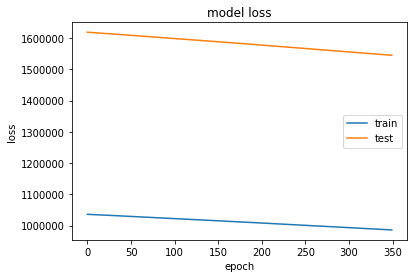

In [52]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

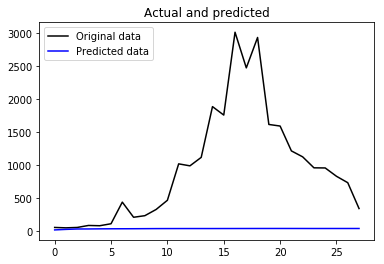

In [53]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель совсем не повторяет структуру данных

#### модель 2, добавили слой, два сигмоида, увеличили кол-во нейронов в первом слое, уменьшили кол-во эпох

In [54]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [55]:
opt = Nadam(lr=0.0001)

In [56]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [57]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 2ms/step - loss: 1037510.5610 - mean_squared_error: 1037510.5610 - val_loss: 1620193.2400 - val_mean_squared_error: 1620193.2400
Epoch 2/250
244/244 [==============================] - 0s 126us/step - loss: 1036279.2344 - mean_squared_error: 1036279.2344 - val_loss: 1618326.4163 - val_mean_squared_error: 1618326.4163
Epoch 3/250
244/244 [==============================] - 0s 152us/step - loss: 1034962.7506 - mean_squared_error: 1034962.7506 - val_loss: 1616361.5469 - val_mean_squared_error: 1616361.5469
Epoch 4/250
244/244 [==============================] - 0s 171us/step - loss: 1033593.8051 - mean_squared_error: 1033593.8051 - val_loss: 1614379.9129 - val_mean_squared_error: 1614379.9129
Epoch 5/250
244/244 [==============================] - 0s 185us/step - loss: 1032225.4900 - mean_squared_error: 1032225.4900 - val_loss: 1612431.3527 - val_mean_squared_error: 1612431.3527
Epoch 6/250


Epoch 44/250
244/244 [==============================] - 0s 201us/step - loss: 1001674.6814 - mean_squared_error: 1001674.6814 - val_loss: 1568296.3460 - val_mean_squared_error: 1568296.3460
Epoch 45/250
244/244 [==============================] - 0s 187us/step - loss: 1001104.6021 - mean_squared_error: 1001104.6021 - val_loss: 1567472.8728 - val_mean_squared_error: 1567472.8728
Epoch 46/250
244/244 [==============================] - 0s 189us/step - loss: 1000548.1361 - mean_squared_error: 1000548.1361 - val_loss: 1566668.1027 - val_mean_squared_error: 1566668.1027
Epoch 47/250
244/244 [==============================] - 0s 188us/step - loss: 1000010.5528 - mean_squared_error: 1000010.5528 - val_loss: 1565848.2210 - val_mean_squared_error: 1565848.2210
Epoch 48/250
244/244 [==============================] - 0s 207us/step - loss: 999452.4474 - mean_squared_error: 999452.4474 - val_loss: 1565052.9263 - val_mean_squared_error: 1565052.9263
Epoch 49/250
244/244 [==============================

244/244 [==============================] - 0s 195us/step - loss: 978972.8032 - mean_squared_error: 978972.8032 - val_loss: 1534857.1864 - val_mean_squared_error: 1534857.1864
Epoch 88/250
244/244 [==============================] - 0s 191us/step - loss: 978470.4823 - mean_squared_error: 978470.4823 - val_loss: 1534109.6150 - val_mean_squared_error: 1534109.6150
Epoch 89/250
244/244 [==============================] - 0s 185us/step - loss: 977962.1320 - mean_squared_error: 977962.1320 - val_loss: 1533343.0781 - val_mean_squared_error: 1533343.0781
Epoch 90/250
244/244 [==============================] - 0s 203us/step - loss: 977447.3408 - mean_squared_error: 977447.3408 - val_loss: 1532580.2489 - val_mean_squared_error: 1532580.2489
Epoch 91/250
244/244 [==============================] - 0s 191us/step - loss: 976928.0976 - mean_squared_error: 976928.0976 - val_loss: 1531819.6641 - val_mean_squared_error: 1531819.6641
Epoch 92/250
244/244 [==============================] - 0s 197us/step - l

244/244 [==============================] - 0s 146us/step - loss: 957311.4951 - mean_squared_error: 957311.4951 - val_loss: 1502673.1406 - val_mean_squared_error: 1502673.1406
Epoch 131/250
244/244 [==============================] - 0s 189us/step - loss: 956824.5122 - mean_squared_error: 956824.5122 - val_loss: 1501949.7946 - val_mean_squared_error: 1501949.7946
Epoch 132/250
244/244 [==============================] - 0s 171us/step - loss: 956346.4631 - mean_squared_error: 956346.4631 - val_loss: 1501236.1562 - val_mean_squared_error: 1501236.1562
Epoch 133/250
244/244 [==============================] - 0s 169us/step - loss: 955876.5420 - mean_squared_error: 955876.5420 - val_loss: 1500519.8103 - val_mean_squared_error: 1500519.8103
Epoch 134/250
244/244 [==============================] - 0s 140us/step - loss: 955397.1633 - mean_squared_error: 955397.1633 - val_loss: 1499821.0324 - val_mean_squared_error: 1499821.0324
Epoch 135/250
244/244 [==============================] - 0s 136us/ste

244/244 [==============================] - 0s 160us/step - loss: 936277.5860 - mean_squared_error: 936277.5860 - val_loss: 1471298.5982 - val_mean_squared_error: 1471298.5982
Epoch 174/250
244/244 [==============================] - 0s 138us/step - loss: 935806.9483 - mean_squared_error: 935806.9483 - val_loss: 1470607.0223 - val_mean_squared_error: 1470607.0223
Epoch 175/250
244/244 [==============================] - 0s 140us/step - loss: 935348.9488 - mean_squared_error: 935348.9488 - val_loss: 1469902.4833 - val_mean_squared_error: 1469902.4833
Epoch 176/250
244/244 [==============================] - 0s 140us/step - loss: 934875.3434 - mean_squared_error: 934875.3434 - val_loss: 1469193.3248 - val_mean_squared_error: 1469193.3248
Epoch 177/250
244/244 [==============================] - 0s 146us/step - loss: 934404.2662 - mean_squared_error: 934404.2662 - val_loss: 1468502.0837 - val_mean_squared_error: 1468502.0837
Epoch 178/250
244/244 [==============================] - 0s 161us/ste

244/244 [==============================] - 0s 167us/step - loss: 916158.9260 - mean_squared_error: 916158.9260 - val_loss: 1441339.2991 - val_mean_squared_error: 1441339.2991
Epoch 217/250
244/244 [==============================] - 0s 175us/step - loss: 915699.1183 - mean_squared_error: 915699.1183 - val_loss: 1440653.6618 - val_mean_squared_error: 1440653.6618
Epoch 218/250
244/244 [==============================] - 0s 172us/step - loss: 915239.7784 - mean_squared_error: 915239.7784 - val_loss: 1439957.1574 - val_mean_squared_error: 1439957.1574
Epoch 219/250
244/244 [==============================] - 0s 142us/step - loss: 914781.7817 - mean_squared_error: 914781.7817 - val_loss: 1439272.0368 - val_mean_squared_error: 1439272.0368
Epoch 220/250
244/244 [==============================] - 0s 142us/step - loss: 914316.2869 - mean_squared_error: 914316.2869 - val_loss: 1438578.2266 - val_mean_squared_error: 1438578.2266
Epoch 221/250
244/244 [==============================] - 0s 165us/ste

#### графики

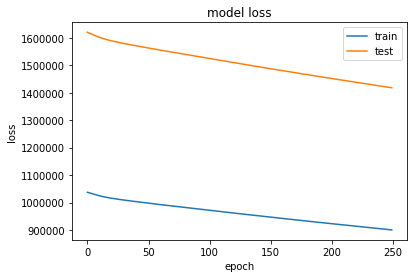

In [58]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

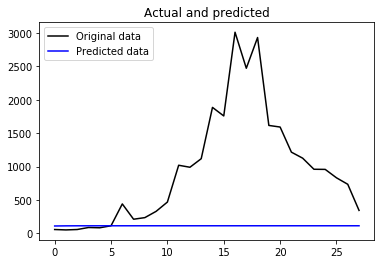

In [59]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

In [60]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('tanh'))
model.add(Dense(360))
model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('linear'))

In [61]:
opt = Nadam(lr=0.0001)

In [62]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [63]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 1ms/step - loss: 1038265.0293 - mean_squared_error: 1038265.0293 - val_loss: 1621891.8080 - val_mean_squared_error: 1621891.8080
Epoch 2/250
244/244 [==============================] - 0s 120us/step - loss: 1036843.1045 - mean_squared_error: 1036843.1045 - val_loss: 1619949.3315 - val_mean_squared_error: 1619949.3315
Epoch 3/250
244/244 [==============================] - 0s 140us/step - loss: 1035239.3468 - mean_squared_error: 1035239.3468 - val_loss: 1617609.7377 - val_mean_squared_error: 1617609.7377
Epoch 4/250
244/244 [==============================] - 0s 130us/step - loss: 1033427.2622 - mean_squared_error: 1033427.2622 - val_loss: 1614926.3147 - val_mean_squared_error: 1614926.3147
Epoch 5/250
244/244 [==============================] - 0s 163us/step - loss: 1031314.9128 - mean_squared_error: 1031314.9128 - val_loss: 1611807.2902 - val_mean_squared_error: 1611807.2902
Epoch 6/250


244/244 [==============================] - 0s 193us/step - loss: 973522.6679 - mean_squared_error: 973522.6679 - val_loss: 1522529.0469 - val_mean_squared_error: 1522529.0469
Epoch 45/250
244/244 [==============================] - 0s 197us/step - loss: 972743.3587 - mean_squared_error: 972743.3587 - val_loss: 1521343.1540 - val_mean_squared_error: 1521343.1540
Epoch 46/250
244/244 [==============================] - 0s 197us/step - loss: 971965.1589 - mean_squared_error: 971965.1589 - val_loss: 1520215.0100 - val_mean_squared_error: 1520215.0100
Epoch 47/250
244/244 [==============================] - 0s 193us/step - loss: 971209.6241 - mean_squared_error: 971209.6241 - val_loss: 1519069.4565 - val_mean_squared_error: 1519069.4565
Epoch 48/250
244/244 [==============================] - 0s 193us/step - loss: 970462.5252 - mean_squared_error: 970462.5252 - val_loss: 1517914.1384 - val_mean_squared_error: 1517914.1384
Epoch 49/250
244/244 [==============================] - 0s 197us/step - l

Epoch 88/250
244/244 [==============================] - 0s 195us/step - loss: 942085.6983 - mean_squared_error: 942085.6983 - val_loss: 1474670.5301 - val_mean_squared_error: 1474670.5301
Epoch 89/250
244/244 [==============================] - 0s 189us/step - loss: 941387.3385 - mean_squared_error: 941387.3385 - val_loss: 1473616.2556 - val_mean_squared_error: 1473616.2556
Epoch 90/250
244/244 [==============================] - 0s 197us/step - loss: 940705.8471 - mean_squared_error: 940705.8471 - val_loss: 1472591.2098 - val_mean_squared_error: 1472591.2098
Epoch 91/250
244/244 [==============================] - 0s 197us/step - loss: 940053.3783 - mean_squared_error: 940053.3783 - val_loss: 1471593.1629 - val_mean_squared_error: 1471593.1629
Epoch 92/250
244/244 [==============================] - 0s 191us/step - loss: 939399.1949 - mean_squared_error: 939399.1949 - val_loss: 1470582.9665 - val_mean_squared_error: 1470582.9665
Epoch 93/250
244/244 [==============================] - 0s 1

244/244 [==============================] - 0s 197us/step - loss: 914218.3975 - mean_squared_error: 914218.3975 - val_loss: 1431863.2857 - val_mean_squared_error: 1431863.2857
Epoch 132/250
244/244 [==============================] - 0s 165us/step - loss: 913567.6199 - mean_squared_error: 913567.6199 - val_loss: 1430866.5435 - val_mean_squared_error: 1430866.5435
Epoch 133/250
244/244 [==============================] - 0s 143us/step - loss: 912922.4859 - mean_squared_error: 912922.4859 - val_loss: 1429881.0045 - val_mean_squared_error: 1429881.0045
Epoch 134/250
244/244 [==============================] - 0s 137us/step - loss: 912286.4160 - mean_squared_error: 912286.4160 - val_loss: 1428938.5882 - val_mean_squared_error: 1428938.5882
Epoch 135/250
244/244 [==============================] - 0s 171us/step - loss: 911673.1777 - mean_squared_error: 911673.1777 - val_loss: 1427998.5547 - val_mean_squared_error: 1427998.5547
Epoch 136/250
244/244 [==============================] - 0s 189us/ste

244/244 [==============================] - 0s 191us/step - loss: 887253.4302 - mean_squared_error: 887253.4302 - val_loss: 1391453.9520 - val_mean_squared_error: 1391453.9520
Epoch 175/250
244/244 [==============================] - 0s 189us/step - loss: 886606.4892 - mean_squared_error: 886606.4892 - val_loss: 1390535.7578 - val_mean_squared_error: 1390535.7578
Epoch 176/250
244/244 [==============================] - 0s 197us/step - loss: 885977.6600 - mean_squared_error: 885977.6600 - val_loss: 1389641.5301 - val_mean_squared_error: 1389641.5301
Epoch 177/250
244/244 [==============================] - 0s 191us/step - loss: 885350.4937 - mean_squared_error: 885350.4937 - val_loss: 1388748.3237 - val_mean_squared_error: 1388748.3237
Epoch 178/250
244/244 [==============================] - 0s 191us/step - loss: 884721.5577 - mean_squared_error: 884721.5577 - val_loss: 1387887.6429 - val_mean_squared_error: 1387887.6429
Epoch 179/250
244/244 [==============================] - 0s 189us/ste

244/244 [==============================] - 0s 181us/step - loss: 856592.5494 - mean_squared_error: 856592.5494 - val_loss: 1352533.2667 - val_mean_squared_error: 1352533.2667
Epoch 218/250
244/244 [==============================] - 0s 217us/step - loss: 855916.4431 - mean_squared_error: 855916.4431 - val_loss: 1351571.9799 - val_mean_squared_error: 1351571.9799
Epoch 219/250
244/244 [==============================] - 0s 134us/step - loss: 855238.7181 - mean_squared_error: 855238.7181 - val_loss: 1350649.7188 - val_mean_squared_error: 1350649.7188
Epoch 220/250
244/244 [==============================] - 0s 136us/step - loss: 854592.4543 - mean_squared_error: 854592.4543 - val_loss: 1349696.6016 - val_mean_squared_error: 1349696.6016
Epoch 221/250
244/244 [==============================] - 0s 136us/step - loss: 853914.6281 - mean_squared_error: 853914.6281 - val_loss: 1348747.5714 - val_mean_squared_error: 1348747.5714
Epoch 222/250
244/244 [==============================] - 0s 197us/ste

#### графики

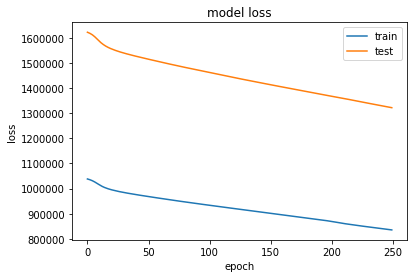

In [64]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

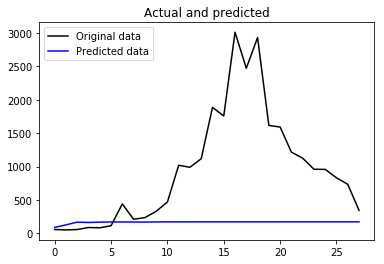

In [65]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

#### модель 4,  добавили reduce lr, вернули sigmoid

In [66]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW))
model.add(Activation('sigmoid'))
model.add(Dense(360))
model.add(Activation('sigmoid'))
model.add(Dense(1))
model.add(Activation('linear'))

In [67]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

!!!!!! ОПИСАТЬ ЧТО ЭТО И ЗАЧЕМ!!!!!

In [68]:
opt = Nadam(lr=0.0001)

In [69]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [70]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 250, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/250
244/244 [==============================] - 0s 2ms/step - loss: 1036490.5799 - mean_squared_error: 1036490.5799 - val_loss: 1618558.2935 - val_mean_squared_error: 1618558.2935

Epoch 00001: val_loss improved from inf to 1618558.29353, saving model to test.hdf5
Epoch 2/250
244/244 [==============================] - 0s 146us/step - loss: 1035149.4887 - mean_squared_error: 1035149.4887 - val_loss: 1616575.2489 - val_mean_squared_error: 1616575.2489

Epoch 00002: val_loss improved from 1618558.29353 to 1616575.24888, saving model to test.hdf5
Epoch 3/250
 15/244 [>.............................] - ETA: 0s - loss: 1491857.5000 - mean_squared_error: 1491857.5000

C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


244/244 [==============================] - 0s 157us/step - loss: 1033773.6859 - mean_squared_error: 1033773.6859 - val_loss: 1614544.1183 - val_mean_squared_error: 1614544.1183

Epoch 00003: val_loss improved from 1616575.24888 to 1614544.11830, saving model to test.hdf5
Epoch 4/250
244/244 [==============================] - 0s 171us/step - loss: 1032358.0505 - mean_squared_error: 1032358.0505 - val_loss: 1612502.9598 - val_mean_squared_error: 1612502.9598

Epoch 00004: val_loss improved from 1614544.11830 to 1612502.95982, saving model to test.hdf5
Epoch 5/250
244/244 [==============================] - 0s 197us/step - loss: 1030982.4376 - mean_squared_error: 1030982.4376 - val_loss: 1610475.3516 - val_mean_squared_error: 1610475.3516

Epoch 00005: val_loss improved from 1612502.95982 to 1610475.35156, saving model to test.hdf5
Epoch 6/250
244/244 [==============================] - 0s 197us/step - loss: 1029601.8657 - mean_squared_error: 1029601.8657 - val_loss: 1608495.4888 - val_mean

244/244 [==============================] - 0s 181us/step - loss: 1007008.7620 - mean_squared_error: 1007008.7620 - val_loss: 1576062.2310 - val_mean_squared_error: 1576062.2310

Epoch 00032: val_loss improved from 1576954.51674 to 1576062.23103, saving model to test.hdf5
Epoch 33/250
244/244 [==============================] - 0s 191us/step - loss: 1006400.2617 - mean_squared_error: 1006400.2617 - val_loss: 1575161.4810 - val_mean_squared_error: 1575161.4810

Epoch 00033: val_loss improved from 1576062.23103 to 1575161.48103, saving model to test.hdf5
Epoch 34/250
244/244 [==============================] - 0s 197us/step - loss: 1005806.3214 - mean_squared_error: 1005806.3214 - val_loss: 1574258.0569 - val_mean_squared_error: 1574258.0569

Epoch 00034: val_loss improved from 1575161.48103 to 1574258.05692, saving model to test.hdf5
Epoch 35/250
244/244 [==============================] - 0s 204us/step - loss: 1005180.0126 - mean_squared_error: 1005180.0126 - val_loss: 1573400.4989 - val_m

244/244 [==============================] - 0s 197us/step - loss: 989990.5396 - mean_squared_error: 989990.5396 - val_loss: 1551050.8415 - val_mean_squared_error: 1551050.8415

Epoch 00061: val_loss improved from 1551945.82478 to 1551050.84152, saving model to test.hdf5
Epoch 62/250
244/244 [==============================] - 0s 203us/step - loss: 989389.3978 - mean_squared_error: 989389.3978 - val_loss: 1550175.5714 - val_mean_squared_error: 1550175.5714

Epoch 00062: val_loss improved from 1551050.84152 to 1550175.57143, saving model to test.hdf5
Epoch 63/250
244/244 [==============================] - 0s 197us/step - loss: 988807.1837 - mean_squared_error: 988807.1837 - val_loss: 1549320.3002 - val_mean_squared_error: 1549320.3002

Epoch 00063: val_loss improved from 1550175.57143 to 1549320.30022, saving model to test.hdf5
Epoch 64/250
244/244 [==============================] - 0s 195us/step - loss: 988225.0458 - mean_squared_error: 988225.0458 - val_loss: 1548465.0781 - val_mean_squa

Epoch 90/250
244/244 [==============================] - 0s 201us/step - loss: 973913.0927 - mean_squared_error: 973913.0927 - val_loss: 1527328.4955 - val_mean_squared_error: 1527328.4955

Epoch 00090: val_loss improved from 1528111.51339 to 1527328.49554, saving model to test.hdf5
Epoch 91/250
244/244 [==============================] - 0s 203us/step - loss: 973382.0223 - mean_squared_error: 973382.0223 - val_loss: 1526557.4297 - val_mean_squared_error: 1526557.4297

Epoch 00091: val_loss improved from 1527328.49554 to 1526557.42969, saving model to test.hdf5
Epoch 92/250
244/244 [==============================] - 0s 196us/step - loss: 972872.2567 - mean_squared_error: 972872.2567 - val_loss: 1525795.8225 - val_mean_squared_error: 1525795.8225

Epoch 00092: val_loss improved from 1526557.42969 to 1525795.82254, saving model to test.hdf5
Epoch 93/250
244/244 [==============================] - 0s 197us/step - loss: 972357.7044 - mean_squared_error: 972357.7044 - val_loss: 1525035.9621 - 

244/244 [==============================] - 0s 195us/step - loss: 959252.3149 - mean_squared_error: 959252.3149 - val_loss: 1505532.2902 - val_mean_squared_error: 1505532.2902

Epoch 00119: val_loss improved from 1506301.51116 to 1505532.29018, saving model to test.hdf5
Epoch 120/250
244/244 [==============================] - 0s 213us/step - loss: 958736.2309 - mean_squared_error: 958736.2309 - val_loss: 1504770.2009 - val_mean_squared_error: 1504770.2009

Epoch 00120: val_loss improved from 1505532.29018 to 1504770.20089, saving model to test.hdf5
Epoch 121/250
244/244 [==============================] - 0s 193us/step - loss: 958217.6975 - mean_squared_error: 958217.6975 - val_loss: 1504000.8817 - val_mean_squared_error: 1504000.8817

Epoch 00121: val_loss improved from 1504770.20089 to 1504000.88170, saving model to test.hdf5
Epoch 122/250
244/244 [==============================] - 0s 193us/step - loss: 957696.9171 - mean_squared_error: 957696.9171 - val_loss: 1503223.5848 - val_mean_s

244/244 [==============================] - 0s 193us/step - loss: 944712.3783 - mean_squared_error: 944712.3783 - val_loss: 1483849.5134 - val_mean_squared_error: 1483849.5134

Epoch 00148: val_loss improved from 1484608.00446 to 1483849.51339, saving model to test.hdf5
Epoch 149/250
244/244 [==============================] - 0s 193us/step - loss: 944203.8144 - mean_squared_error: 944203.8144 - val_loss: 1483089.8929 - val_mean_squared_error: 1483089.8929

Epoch 00149: val_loss improved from 1483849.51339 to 1483089.89286, saving model to test.hdf5
Epoch 150/250
244/244 [==============================] - 0s 199us/step - loss: 943704.2896 - mean_squared_error: 943704.2896 - val_loss: 1482350.5179 - val_mean_squared_error: 1482350.5179

Epoch 00150: val_loss improved from 1483089.89286 to 1482350.51786, saving model to test.hdf5
Epoch 151/250
244/244 [==============================] - 0s 148us/step - loss: 943206.1323 - mean_squared_error: 943206.1323 - val_loss: 1481612.9074 - val_mean_s

244/244 [==============================] - 0s 150us/step - loss: 930562.3039 - mean_squared_error: 930562.3039 - val_loss: 1462748.8248 - val_mean_squared_error: 1462748.8248

Epoch 00177: val_loss improved from 1463462.21205 to 1462748.82478, saving model to test.hdf5
Epoch 178/250
244/244 [==============================] - 0s 142us/step - loss: 930086.9465 - mean_squared_error: 930086.9465 - val_loss: 1462047.7366 - val_mean_squared_error: 1462047.7366

Epoch 00178: val_loss improved from 1462748.82478 to 1462047.73661, saving model to test.hdf5
Epoch 179/250
244/244 [==============================] - 0s 159us/step - loss: 929615.1402 - mean_squared_error: 929615.1402 - val_loss: 1461330.4621 - val_mean_squared_error: 1461330.4621

Epoch 00179: val_loss improved from 1462047.73661 to 1461330.46205, saving model to test.hdf5
Epoch 180/250
244/244 [==============================] - 0s 175us/step - loss: 929146.7692 - mean_squared_error: 929146.7692 - val_loss: 1460629.7243 - val_mean_s

244/244 [==============================] - 0s 209us/step - loss: 916758.8745 - mean_squared_error: 916758.8745 - val_loss: 1442194.9978 - val_mean_squared_error: 1442194.9978

Epoch 00206: val_loss improved from 1442865.61272 to 1442194.99777, saving model to test.hdf5
Epoch 207/250
244/244 [==============================] - 0s 195us/step - loss: 916310.4849 - mean_squared_error: 916310.4849 - val_loss: 1441516.9051 - val_mean_squared_error: 1441516.9051

Epoch 00207: val_loss improved from 1442194.99777 to 1441516.90513, saving model to test.hdf5
Epoch 208/250
244/244 [==============================] - 0s 195us/step - loss: 915847.2878 - mean_squared_error: 915847.2878 - val_loss: 1440846.1094 - val_mean_squared_error: 1440846.1094

Epoch 00208: val_loss improved from 1441516.90513 to 1440846.10938, saving model to test.hdf5
Epoch 209/250
244/244 [==============================] - 0s 201us/step - loss: 915388.4977 - mean_squared_error: 915388.4977 - val_loss: 1440135.2790 - val_mean_s

Epoch 235/250
244/244 [==============================] - 0s 201us/step - loss: 903475.3005 - mean_squared_error: 903475.3005 - val_loss: 1422399.9665 - val_mean_squared_error: 1422399.9665

Epoch 00235: val_loss improved from 1423083.75112 to 1422399.96652, saving model to test.hdf5
Epoch 236/250
244/244 [==============================] - 0s 199us/step - loss: 903006.9376 - mean_squared_error: 903006.9376 - val_loss: 1421712.0770 - val_mean_squared_error: 1421712.0770

Epoch 00236: val_loss improved from 1422399.96652 to 1421712.07701, saving model to test.hdf5
Epoch 237/250
244/244 [==============================] - 0s 203us/step - loss: 902534.2614 - mean_squared_error: 902534.2614 - val_loss: 1421000.7076 - val_mean_squared_error: 1421000.7076

Epoch 00237: val_loss improved from 1421712.07701 to 1421000.70759, saving model to test.hdf5
Epoch 238/250
244/244 [==============================] - 0s 201us/step - loss: 902060.2981 - mean_squared_error: 902060.2981 - val_loss: 1420229.082

#### графики

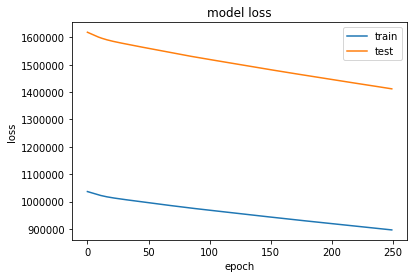

In [71]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

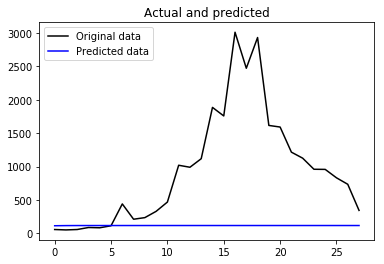

In [72]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель не работает

#### увеличили шаг, добавили регуляризацию, заменили сигмоид на релу

In [73]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

In [74]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [75]:
opt = Nadam(lr=0.001)

In [76]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [77]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 0s 2ms/step - loss: 1032842.8349 - mean_squared_error: 1032841.1467 - val_loss: 1597046.6473 - val_mean_squared_error: 1597042.7779

Epoch 00001: val_loss improved from inf to 1597046.64732, saving model to test.hdf5
Epoch 2/550
240/244 [============================>.] - ETA: 0s - loss: 994841.0000 - mean_squared_error: 994831.1587

C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


244/244 [==============================] - 0s 262us/step - loss: 998878.4283 - mean_squared_error: 998868.6684 - val_loss: 1506269.1618 - val_mean_squared_error: 1506240.8292

Epoch 00002: val_loss improved from 1597046.64732 to 1506269.16183, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 260us/step - loss: 891992.4622 - mean_squared_error: 891934.6587 - val_loss: 1264104.0536 - val_mean_squared_error: 1263943.4710

Epoch 00003: val_loss improved from 1506269.16183 to 1264104.05357, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 238us/step - loss: 690999.1670 - mean_squared_error: 690756.1234 - val_loss: 935142.5798 - val_mean_squared_error: 934646.1959

Epoch 00004: val_loss improved from 1264104.05357 to 935142.57980, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 236us/step - loss: 473884.5699 - mean_squared_error: 473286.5118 - val_loss: 643906.4509 - val_mean_squared_err

244/244 [==============================] - 0s 213us/step - loss: 154821.6201 - mean_squared_error: 152951.8286 - val_loss: 365467.4166 - val_mean_squared_error: 362736.8783

Epoch 00033: val_loss did not improve from 363943.36663
Epoch 34/550
244/244 [==============================] - 0s 224us/step - loss: 153481.0147 - mean_squared_error: 151649.8206 - val_loss: 363704.0343 - val_mean_squared_error: 360950.6264

Epoch 00034: val_loss improved from 363943.36663 to 363704.03432, saving model to test.hdf5
Epoch 35/550
244/244 [==============================] - 0s 209us/step - loss: 153234.9855 - mean_squared_error: 151381.4304 - val_loss: 379725.6002 - val_mean_squared_error: 376895.7561

Epoch 00035: val_loss did not improve from 363704.03432
Epoch 36/550
244/244 [==============================] - 0s 213us/step - loss: 150926.8172 - mean_squared_error: 149013.5742 - val_loss: 387422.5985 - val_mean_squared_error: 384557.8002

Epoch 00036: val_loss did not improve from 363704.03432
Epoch

244/244 [==============================] - 0s 213us/step - loss: 120545.5916 - mean_squared_error: 117985.7119 - val_loss: 383340.3097 - val_mean_squared_error: 379518.1052

Epoch 00066: val_loss did not improve from 357956.79241
Epoch 67/550
244/244 [==============================] - 0s 211us/step - loss: 120643.8804 - mean_squared_error: 118009.2469 - val_loss: 387614.2254 - val_mean_squared_error: 383823.9634

Epoch 00067: val_loss did not improve from 357956.79241
Epoch 68/550
244/244 [==============================] - 0s 218us/step - loss: 118709.3461 - mean_squared_error: 116145.8826 - val_loss: 378261.4319 - val_mean_squared_error: 374286.7274

Epoch 00068: val_loss did not improve from 357956.79241
Epoch 69/550
244/244 [==============================] - 0s 211us/step - loss: 119513.5273 - mean_squared_error: 116782.3957 - val_loss: 395983.8647 - val_mean_squared_error: 392184.1702

Epoch 00069: val_loss did not improve from 357956.79241
Epoch 70/550
244/244 [===================

244/244 [==============================] - 0s 209us/step - loss: 94088.3291 - mean_squared_error: 91022.2278 - val_loss: 413882.6942 - val_mean_squared_error: 409558.4046

Epoch 00100: val_loss did not improve from 357956.79241
Epoch 101/550
244/244 [==============================] - 0s 213us/step - loss: 95273.8489 - mean_squared_error: 92158.8014 - val_loss: 410699.4581 - val_mean_squared_error: 406434.6950

Epoch 00101: val_loss did not improve from 357956.79241
Epoch 102/550
244/244 [==============================] - 0s 211us/step - loss: 92777.4186 - mean_squared_error: 89668.6182 - val_loss: 384738.5435 - val_mean_squared_error: 380404.3306

Epoch 00102: val_loss did not improve from 357956.79241
Epoch 103/550
244/244 [==============================] - 0s 213us/step - loss: 92329.2857 - mean_squared_error: 89213.6121 - val_loss: 394240.3245 - val_mean_squared_error: 389873.1878

Epoch 00103: val_loss did not improve from 357956.79241
Epoch 104/550
244/244 [=======================

244/244 [==============================] - 0s 209us/step - loss: 79434.1868 - mean_squared_error: 76048.5050 - val_loss: 416761.1317 - val_mean_squared_error: 412214.2017

Epoch 00134: val_loss did not improve from 357956.79241
Epoch 135/550
244/244 [==============================] - 0s 201us/step - loss: 77376.6716 - mean_squared_error: 73977.2576 - val_loss: 435349.0502 - val_mean_squared_error: 430797.8440

Epoch 00135: val_loss did not improve from 357956.79241
Epoch 136/550
244/244 [==============================] - 0s 217us/step - loss: 76924.0970 - mean_squared_error: 73519.4464 - val_loss: 426193.5424 - val_mean_squared_error: 421610.0176

Epoch 00136: val_loss did not improve from 357956.79241
Epoch 137/550
244/244 [==============================] - 0s 197us/step - loss: 76325.2999 - mean_squared_error: 72954.3205 - val_loss: 441451.4821 - val_mean_squared_error: 436891.6484

Epoch 00137: val_loss did not improve from 357956.79241
Epoch 138/550
244/244 [=======================

244/244 [==============================] - 0s 179us/step - loss: 69458.1380 - mean_squared_error: 66015.3989 - val_loss: 389427.4727 - val_mean_squared_error: 384739.1490

Epoch 00168: val_loss did not improve from 357956.79241
Epoch 169/550
244/244 [==============================] - 0s 163us/step - loss: 68407.1781 - mean_squared_error: 64940.2342 - val_loss: 403351.7115 - val_mean_squared_error: 398763.6189

Epoch 00169: val_loss did not improve from 357956.79241
Epoch 170/550
244/244 [==============================] - 0s 161us/step - loss: 67252.3887 - mean_squared_error: 63838.2363 - val_loss: 381758.5285 - val_mean_squared_error: 377163.6334

Epoch 00170: val_loss did not improve from 357956.79241
Epoch 171/550
244/244 [==============================] - 0s 173us/step - loss: 67387.0550 - mean_squared_error: 63971.1365 - val_loss: 459149.8705 - val_mean_squared_error: 454735.2578

Epoch 00171: val_loss did not improve from 357956.79241
Epoch 172/550
244/244 [=======================

244/244 [==============================] - 0s 207us/step - loss: 59906.8003 - mean_squared_error: 56574.4399 - val_loss: 415469.2578 - val_mean_squared_error: 410992.9788

Epoch 00202: val_loss did not improve from 357956.79241
Epoch 203/550
244/244 [==============================] - 0s 209us/step - loss: 58869.7533 - mean_squared_error: 55579.1554 - val_loss: 439387.9975 - val_mean_squared_error: 434789.0405

Epoch 00203: val_loss did not improve from 357956.79241
Epoch 204/550
244/244 [==============================] - 0s 209us/step - loss: 58929.8727 - mean_squared_error: 55525.8763 - val_loss: 407447.5801 - val_mean_squared_error: 402857.5206

Epoch 00204: val_loss did not improve from 357956.79241
Epoch 205/550
244/244 [==============================] - 0s 215us/step - loss: 58651.7570 - mean_squared_error: 55290.1667 - val_loss: 402325.4383 - val_mean_squared_error: 397710.1278

Epoch 00205: val_loss did not improve from 357956.79241
Epoch 206/550
244/244 [=======================

244/244 [==============================] - 0s 215us/step - loss: 52351.4863 - mean_squared_error: 49103.1303 - val_loss: 397295.3811 - val_mean_squared_error: 392862.1141

Epoch 00236: val_loss did not improve from 357956.79241
Epoch 237/550
244/244 [==============================] - 0s 211us/step - loss: 52776.9932 - mean_squared_error: 49577.1459 - val_loss: 410106.5809 - val_mean_squared_error: 405699.3622

Epoch 00237: val_loss did not improve from 357956.79241
Epoch 238/550
244/244 [==============================] - 0s 212us/step - loss: 52446.9638 - mean_squared_error: 49254.6151 - val_loss: 422418.5829 - val_mean_squared_error: 417976.0603

Epoch 00238: val_loss did not improve from 357956.79241
Epoch 239/550
244/244 [==============================] - 0s 195us/step - loss: 51391.4534 - mean_squared_error: 48159.4181 - val_loss: 435734.7737 - val_mean_squared_error: 431342.7193

Epoch 00239: val_loss did not improve from 357956.79241
Epoch 240/550
244/244 [=======================

244/244 [==============================] - 0s 215us/step - loss: 46670.0982 - mean_squared_error: 43603.0029 - val_loss: 385716.8733 - val_mean_squared_error: 381433.2896

Epoch 00270: val_loss did not improve from 357956.79241
Epoch 271/550
244/244 [==============================] - 0s 220us/step - loss: 47123.0021 - mean_squared_error: 44045.3350 - val_loss: 409444.3237 - val_mean_squared_error: 405087.8781

Epoch 00271: val_loss did not improve from 357956.79241
Epoch 272/550
244/244 [==============================] - 0s 218us/step - loss: 46067.8918 - mean_squared_error: 43004.5397 - val_loss: 407900.0310 - val_mean_squared_error: 403508.9300

Epoch 00272: val_loss did not improve from 357956.79241
Epoch 273/550
244/244 [==============================] - 0s 220us/step - loss: 47230.3295 - mean_squared_error: 44161.0874 - val_loss: 387384.3398 - val_mean_squared_error: 383009.2799

Epoch 00273: val_loss did not improve from 357956.79241
Epoch 274/550
244/244 [=======================

244/244 [==============================] - 0s 240us/step - loss: 40580.3195 - mean_squared_error: 37558.7483 - val_loss: 408226.9707 - val_mean_squared_error: 403915.0142

Epoch 00304: val_loss did not improve from 357956.79241
Epoch 305/550
244/244 [==============================] - 0s 233us/step - loss: 39916.7335 - mean_squared_error: 36897.9664 - val_loss: 406463.0508 - val_mean_squared_error: 402214.5896

Epoch 00305: val_loss did not improve from 357956.79241
Epoch 306/550
244/244 [==============================] - 0s 195us/step - loss: 40309.5698 - mean_squared_error: 37346.6445 - val_loss: 395487.9015 - val_mean_squared_error: 391206.7665

Epoch 00306: val_loss did not improve from 357956.79241
Epoch 307/550
244/244 [==============================] - 0s 156us/step - loss: 39734.8732 - mean_squared_error: 36747.4321 - val_loss: 398921.6066 - val_mean_squared_error: 394594.8510

Epoch 00307: val_loss did not improve from 357956.79241
Epoch 308/550
244/244 [=======================

244/244 [==============================] - 0s 220us/step - loss: 35653.1469 - mean_squared_error: 32809.8969 - val_loss: 398621.4330 - val_mean_squared_error: 394449.0212

Epoch 00338: val_loss did not improve from 357956.79241
Epoch 339/550
244/244 [==============================] - 0s 211us/step - loss: 36009.3548 - mean_squared_error: 33139.5473 - val_loss: 395713.8577 - val_mean_squared_error: 391541.6819

Epoch 00339: val_loss did not improve from 357956.79241
Epoch 340/550
244/244 [==============================] - 0s 211us/step - loss: 35744.5608 - mean_squared_error: 32879.0091 - val_loss: 422264.3725 - val_mean_squared_error: 418045.7171

Epoch 00340: val_loss did not improve from 357956.79241
Epoch 341/550
244/244 [==============================] - 0s 212us/step - loss: 35260.8949 - mean_squared_error: 32380.1005 - val_loss: 398148.0505 - val_mean_squared_error: 393947.1214

Epoch 00341: val_loss did not improve from 357956.79241
Epoch 342/550
244/244 [=======================

244/244 [==============================] - 0s 173us/step - loss: 30574.5178 - mean_squared_error: 27807.0363 - val_loss: 415959.6878 - val_mean_squared_error: 411863.6334

Epoch 00372: val_loss did not improve from 357956.79241
Epoch 373/550
244/244 [==============================] - 0s 209us/step - loss: 31113.7829 - mean_squared_error: 28359.5683 - val_loss: 402130.2464 - val_mean_squared_error: 398080.0110

Epoch 00373: val_loss did not improve from 357956.79241
Epoch 374/550
244/244 [==============================] - 0s 224us/step - loss: 30127.3740 - mean_squared_error: 27372.0208 - val_loss: 396412.1412 - val_mean_squared_error: 392383.4565

Epoch 00374: val_loss did not improve from 357956.79241
Epoch 375/550
244/244 [==============================] - 0s 213us/step - loss: 30639.8486 - mean_squared_error: 27930.8608 - val_loss: 411024.6694 - val_mean_squared_error: 407001.2439

Epoch 00375: val_loss did not improve from 357956.79241
Epoch 376/550
244/244 [=======================

244/244 [==============================] - 0s 215us/step - loss: 26700.3042 - mean_squared_error: 24003.8637 - val_loss: 419830.3836 - val_mean_squared_error: 415918.9707

Epoch 00406: val_loss did not improve from 357956.79241
Epoch 407/550
244/244 [==============================] - 0s 224us/step - loss: 27773.6085 - mean_squared_error: 25073.3764 - val_loss: 435668.9012 - val_mean_squared_error: 431723.1847

Epoch 00407: val_loss did not improve from 357956.79241
Epoch 408/550
244/244 [==============================] - 0s 215us/step - loss: 26786.4170 - mean_squared_error: 24087.8598 - val_loss: 386390.3235 - val_mean_squared_error: 382428.2864

Epoch 00408: val_loss did not improve from 357956.79241
Epoch 409/550
244/244 [==============================] - 0s 211us/step - loss: 27078.7914 - mean_squared_error: 24414.4326 - val_loss: 409829.9561 - val_mean_squared_error: 405848.5038

Epoch 00409: val_loss did not improve from 357956.79241
Epoch 410/550
244/244 [=======================

244/244 [==============================] - 0s 201us/step - loss: 24025.3224 - mean_squared_error: 21382.4019 - val_loss: 389764.1405 - val_mean_squared_error: 385923.5188

Epoch 00440: val_loss did not improve from 357956.79241
Epoch 441/550
244/244 [==============================] - 0s 173us/step - loss: 23922.8760 - mean_squared_error: 21293.2486 - val_loss: 390133.5410 - val_mean_squared_error: 386301.9997

Epoch 00441: val_loss did not improve from 357956.79241
Epoch 442/550
244/244 [==============================] - 0s 195us/step - loss: 23887.9607 - mean_squared_error: 21243.6974 - val_loss: 429808.7750 - val_mean_squared_error: 425977.1830

Epoch 00442: val_loss did not improve from 357956.79241
Epoch 443/550
244/244 [==============================] - 0s 173us/step - loss: 22987.9704 - mean_squared_error: 20367.0625 - val_loss: 396720.6537 - val_mean_squared_error: 392849.5006

Epoch 00443: val_loss did not improve from 357956.79241
Epoch 444/550
244/244 [=======================

244/244 [==============================] - 0s 169us/step - loss: 20553.6998 - mean_squared_error: 17968.2324 - val_loss: 428985.8092 - val_mean_squared_error: 425287.9226

Epoch 00474: val_loss did not improve from 357956.79241
Epoch 475/550
244/244 [==============================] - 0s 171us/step - loss: 20455.5955 - mean_squared_error: 17846.3984 - val_loss: 415403.0550 - val_mean_squared_error: 411661.2665

Epoch 00475: val_loss did not improve from 357956.79241
Epoch 476/550
244/244 [==============================] - 0s 191us/step - loss: 20395.9057 - mean_squared_error: 17818.7971 - val_loss: 424757.9852 - val_mean_squared_error: 421068.5405

Epoch 00476: val_loss did not improve from 357956.79241
Epoch 477/550
244/244 [==============================] - 0s 165us/step - loss: 20549.6986 - mean_squared_error: 17997.9103 - val_loss: 437155.7744 - val_mean_squared_error: 433482.2646

Epoch 00477: val_loss did not improve from 357956.79241
Epoch 478/550
244/244 [=======================

244/244 [==============================] - 0s 181us/step - loss: 18109.7987 - mean_squared_error: 15580.7155 - val_loss: 420468.5798 - val_mean_squared_error: 416823.3062

Epoch 00508: val_loss did not improve from 357956.79241
Epoch 509/550
244/244 [==============================] - 0s 179us/step - loss: 18440.3419 - mean_squared_error: 15907.2495 - val_loss: 416717.2132 - val_mean_squared_error: 413129.9323

Epoch 00509: val_loss did not improve from 357956.79241
Epoch 510/550
244/244 [==============================] - 0s 150us/step - loss: 18224.2618 - mean_squared_error: 15724.2884 - val_loss: 418493.0402 - val_mean_squared_error: 414867.1613

Epoch 00510: val_loss did not improve from 357956.79241
Epoch 511/550
244/244 [==============================] - 0s 132us/step - loss: 18908.5549 - mean_squared_error: 16441.5508 - val_loss: 417671.1350 - val_mean_squared_error: 414023.4869

Epoch 00511: val_loss did not improve from 357956.79241
Epoch 512/550
244/244 [=======================

244/244 [==============================] - 0s 201us/step - loss: 16422.9183 - mean_squared_error: 14027.1384 - val_loss: 415704.8694 - val_mean_squared_error: 412271.2340

Epoch 00542: val_loss did not improve from 357956.79241
Epoch 543/550
244/244 [==============================] - 0s 165us/step - loss: 16074.0210 - mean_squared_error: 13637.4462 - val_loss: 419597.6066 - val_mean_squared_error: 416098.6472

Epoch 00543: val_loss did not improve from 357956.79241
Epoch 544/550
244/244 [==============================] - 0s 236us/step - loss: 16319.7306 - mean_squared_error: 13869.4154 - val_loss: 422814.5029 - val_mean_squared_error: 419284.3708

Epoch 00544: val_loss did not improve from 357956.79241
Epoch 545/550
244/244 [==============================] - 0s 226us/step - loss: 16443.3397 - mean_squared_error: 13988.1682 - val_loss: 402834.6525 - val_mean_squared_error: 399335.5935

Epoch 00545: val_loss did not improve from 357956.79241
Epoch 546/550
244/244 [=======================

#### графики

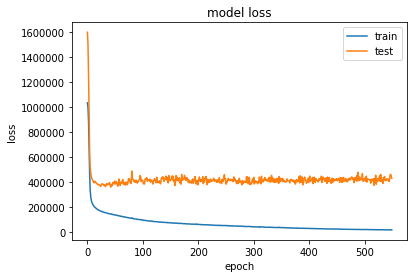

In [78]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

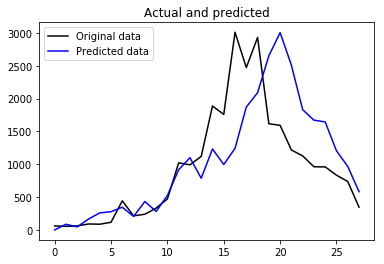

In [79]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель начала повторять структуру графика, мы на верном пути

#### модель 6 добавили batch normalization

In [80]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))

!!!! ОПИСАТЬ ЧТО ТАКОЕ BATCH NORMALIZATION !!!!!

In [81]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [82]:
opt = Nadam(lr=0.001)

In [83]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [84]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 1s 5ms/step - loss: 1032204.0377 - mean_squared_error: 1032201.5126 - val_loss: 1604091.7980 - val_mean_squared_error: 1604089.3482

Epoch 00001: val_loss improved from inf to 1604091.79799, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
244/244 [==============================] - 0s 342us/step - loss: 1021490.5562 - mean_squared_error: 1021487.6738 - val_loss: 1589781.9922 - val_mean_squared_error: 1589779.5268

Epoch 00002: val_loss improved from 1604091.79799 to 1589781.99219, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 186us/step - loss: 1012761.7445 - mean_squared_error: 1012758.5230 - val_loss: 1575158.0960 - val_mean_squared_error: 1575155.3650

Epoch 00003: val_loss improved from 1589781.99219 to 1575158.09598, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 185us/step - loss: 1003135.0903 - mean_squared_error: 1003131.5257 - val_loss: 1560325.0580 - val_mean_squared_error: 1560321.8125

Epoch 00004: val_loss improved from 1575158.09598 to 1560325.05804, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 175us/step - loss: 995012.4985 - mean_squared_error: 995008.6947 - val_loss: 1546053.4911 


Epoch 00031: val_loss did not improve from 827295.62277
Epoch 32/550
244/244 [==============================] - 0s 274us/step - loss: 510731.3813 - mean_squared_error: 510723.7301 - val_loss: 901866.4911 - val_mean_squared_error: 901854.8683

Epoch 00032: val_loss did not improve from 827295.62277
Epoch 33/550
244/244 [==============================] - 0s 270us/step - loss: 465453.3277 - mean_squared_error: 465445.3413 - val_loss: 987041.1540 - val_mean_squared_error: 987028.0112

Epoch 00033: val_loss did not improve from 827295.62277
Epoch 34/550
244/244 [==============================] - 0s 281us/step - loss: 457118.3124 - mean_squared_error: 457110.0384 - val_loss: 795866.2254 - val_mean_squared_error: 795854.1484

Epoch 00034: val_loss improved from 827295.62277 to 795866.22545, saving model to test.hdf5
Epoch 35/550
244/244 [==============================] - 0s 260us/step - loss: 417385.4131 - mean_squared_error: 417377.1422 - val_loss: 754447.5692 - val_mean_squared_error: 7544

244/244 [==============================] - 0s 285us/step - loss: 156742.5491 - mean_squared_error: 156734.9115 - val_loss: 461629.4927 - val_mean_squared_error: 461619.9760

Epoch 00064: val_loss did not improve from 382775.19308
Epoch 65/550
244/244 [==============================] - 0s 268us/step - loss: 146350.9288 - mean_squared_error: 146343.4769 - val_loss: 526779.5977 - val_mean_squared_error: 526769.4944

Epoch 00065: val_loss did not improve from 382775.19308
Epoch 66/550
244/244 [==============================] - 0s 270us/step - loss: 120078.9716 - mean_squared_error: 120070.8607 - val_loss: 433173.2879 - val_mean_squared_error: 433164.3895

Epoch 00066: val_loss did not improve from 382775.19308
Epoch 67/550
244/244 [==============================] - 0s 213us/step - loss: 154199.2238 - mean_squared_error: 154191.4170 - val_loss: 496833.0257 - val_mean_squared_error: 496823.9587

Epoch 00067: val_loss did not improve from 382775.19308
Epoch 68/550
244/244 [===================


Epoch 00097: val_loss did not improve from 369673.95536
Epoch 98/550
244/244 [==============================] - 0s 211us/step - loss: 117877.5469 - mean_squared_error: 117870.3247 - val_loss: 568667.3965 - val_mean_squared_error: 568658.1211

Epoch 00098: val_loss did not improve from 369673.95536
Epoch 99/550
244/244 [==============================] - 0s 205us/step - loss: 91953.9738 - mean_squared_error: 91946.6955 - val_loss: 607733.5181 - val_mean_squared_error: 607724.0165

Epoch 00099: val_loss did not improve from 369673.95536
Epoch 100/550
244/244 [==============================] - 0s 209us/step - loss: 106774.8742 - mean_squared_error: 106767.3205 - val_loss: 558364.8203 - val_mean_squared_error: 558355.6219

Epoch 00100: val_loss did not improve from 369673.95536
Epoch 101/550
244/244 [==============================] - 0s 227us/step - loss: 78521.4566 - mean_squared_error: 78513.8568 - val_loss: 566410.3438 - val_mean_squared_error: 566401.3351

Epoch 00101: val_loss did not


Epoch 00131: val_loss did not improve from 369673.95536
Epoch 132/550
244/244 [==============================] - 0s 211us/step - loss: 109438.7252 - mean_squared_error: 109432.0677 - val_loss: 613915.2132 - val_mean_squared_error: 613906.5352

Epoch 00132: val_loss did not improve from 369673.95536
Epoch 133/550
244/244 [==============================] - 0s 252us/step - loss: 90544.5162 - mean_squared_error: 90537.7185 - val_loss: 625776.8435 - val_mean_squared_error: 625768.6543

Epoch 00133: val_loss did not improve from 369673.95536
Epoch 134/550
244/244 [==============================] - 0s 222us/step - loss: 73574.2612 - mean_squared_error: 73567.7200 - val_loss: 688989.4819 - val_mean_squared_error: 688980.4342

Epoch 00134: val_loss did not improve from 369673.95536
Epoch 135/550
244/244 [==============================] - 0s 236us/step - loss: 81779.4467 - mean_squared_error: 81772.1395 - val_loss: 633470.2969 - val_mean_squared_error: 633461.3962

Epoch 00135: val_loss did not


Epoch 00165: val_loss did not improve from 369673.95536
Epoch 166/550
244/244 [==============================] - 0s 234us/step - loss: 98053.2626 - mean_squared_error: 98046.5253 - val_loss: 541198.6094 - val_mean_squared_error: 541190.2681

Epoch 00166: val_loss did not improve from 369673.95536
Epoch 167/550
244/244 [==============================] - 0s 254us/step - loss: 76613.5564 - mean_squared_error: 76606.5062 - val_loss: 599839.4528 - val_mean_squared_error: 599830.9369

Epoch 00167: val_loss did not improve from 369673.95536
Epoch 168/550
244/244 [==============================] - 0s 258us/step - loss: 82169.1849 - mean_squared_error: 82162.3704 - val_loss: 647258.1264 - val_mean_squared_error: 647249.7160

Epoch 00168: val_loss did not improve from 369673.95536
Epoch 169/550
244/244 [==============================] - 0s 245us/step - loss: 81111.0627 - mean_squared_error: 81104.5447 - val_loss: 712113.6110 - val_mean_squared_error: 712104.9967

Epoch 00169: val_loss did not i


Epoch 00199: val_loss did not improve from 369673.95536
Epoch 200/550
244/244 [==============================] - 0s 264us/step - loss: 76842.5230 - mean_squared_error: 76835.1424 - val_loss: 550808.3650 - val_mean_squared_error: 550799.6755

Epoch 00200: val_loss did not improve from 369673.95536
Epoch 201/550
244/244 [==============================] - 0s 274us/step - loss: 90558.6571 - mean_squared_error: 90551.6296 - val_loss: 614603.2631 - val_mean_squared_error: 614594.3513

Epoch 00201: val_loss did not improve from 369673.95536
Epoch 202/550
244/244 [==============================] - 0s 266us/step - loss: 62083.2989 - mean_squared_error: 62076.1281 - val_loss: 735843.1108 - val_mean_squared_error: 735833.8516

Epoch 00202: val_loss did not improve from 369673.95536
Epoch 203/550
244/244 [==============================] - 0s 270us/step - loss: 70012.7677 - mean_squared_error: 70005.5099 - val_loss: 627955.1122 - val_mean_squared_error: 627946.3354

Epoch 00203: val_loss did not i


Epoch 00233: val_loss did not improve from 369673.95536
Epoch 234/550
244/244 [==============================] - 0s 252us/step - loss: 85780.1683 - mean_squared_error: 85773.2049 - val_loss: 684154.8873 - val_mean_squared_error: 684145.7296

Epoch 00234: val_loss did not improve from 369673.95536
Epoch 235/550
244/244 [==============================] - 0s 225us/step - loss: 63895.7006 - mean_squared_error: 63888.7365 - val_loss: 644657.2999 - val_mean_squared_error: 644648.7559

Epoch 00235: val_loss did not improve from 369673.95536
Epoch 236/550
244/244 [==============================] - 0s 226us/step - loss: 84211.8451 - mean_squared_error: 84205.0040 - val_loss: 593301.6733 - val_mean_squared_error: 593293.6652

Epoch 00236: val_loss did not improve from 369673.95536
Epoch 237/550
244/244 [==============================] - 0s 240us/step - loss: 88836.9330 - mean_squared_error: 88830.5660 - val_loss: 536747.3156 - val_mean_squared_error: 536739.2793

Epoch 00237: val_loss did not i


Epoch 00267: val_loss did not improve from 369673.95536
Epoch 268/550
244/244 [==============================] - 0s 236us/step - loss: 96359.3045 - mean_squared_error: 96352.6485 - val_loss: 659241.9350 - val_mean_squared_error: 659232.8814

Epoch 00268: val_loss did not improve from 369673.95536
Epoch 269/550
244/244 [==============================] - 0s 220us/step - loss: 81442.0778 - mean_squared_error: 81434.7786 - val_loss: 542366.8622 - val_mean_squared_error: 542358.4456

Epoch 00269: val_loss did not improve from 369673.95536
Epoch 270/550
244/244 [==============================] - 0s 248us/step - loss: 93466.2030 - mean_squared_error: 93459.3060 - val_loss: 608756.2550 - val_mean_squared_error: 608747.8474

Epoch 00270: val_loss did not improve from 369673.95536
Epoch 271/550
244/244 [==============================] - 0s 226us/step - loss: 85538.6173 - mean_squared_error: 85532.1052 - val_loss: 658330.4961 - val_mean_squared_error: 658321.7109

Epoch 00271: val_loss did not i


Epoch 00301: val_loss did not improve from 369673.95536
Epoch 302/550
244/244 [==============================] - 0s 197us/step - loss: 83680.8101 - mean_squared_error: 83674.2398 - val_loss: 572783.0438 - val_mean_squared_error: 572775.1463

Epoch 00302: val_loss did not improve from 369673.95536
Epoch 303/550
244/244 [==============================] - 0s 201us/step - loss: 54436.9856 - mean_squared_error: 54430.2692 - val_loss: 704265.3756 - val_mean_squared_error: 704257.0064

Epoch 00303: val_loss did not improve from 369673.95536
Epoch 304/550
244/244 [==============================] - 0s 195us/step - loss: 78381.3932 - mean_squared_error: 78374.4947 - val_loss: 638478.2665 - val_mean_squared_error: 638470.3309

Epoch 00304: val_loss did not improve from 369673.95536
Epoch 305/550
244/244 [==============================] - 0s 211us/step - loss: 97447.7552 - mean_squared_error: 97441.3801 - val_loss: 504080.7536 - val_mean_squared_error: 504073.0857

Epoch 00305: val_loss did not i


Epoch 00335: val_loss did not improve from 369673.95536
Epoch 336/550
244/244 [==============================] - 0s 207us/step - loss: 90248.5423 - mean_squared_error: 90240.9779 - val_loss: 643524.7105 - val_mean_squared_error: 643515.0936

Epoch 00336: val_loss did not improve from 369673.95536
Epoch 337/550
244/244 [==============================] - 0s 264us/step - loss: 61783.4403 - mean_squared_error: 61776.4671 - val_loss: 564865.4849 - val_mean_squared_error: 564856.2729

Epoch 00337: val_loss did not improve from 369673.95536
Epoch 338/550
244/244 [==============================] - 0s 264us/step - loss: 70639.6449 - mean_squared_error: 70632.1094 - val_loss: 668768.8083 - val_mean_squared_error: 668759.2810

Epoch 00338: val_loss did not improve from 369673.95536
Epoch 339/550
244/244 [==============================] - 0s 264us/step - loss: 96282.9288 - mean_squared_error: 96275.6658 - val_loss: 570662.2112 - val_mean_squared_error: 570653.2806

Epoch 00339: val_loss did not i


Epoch 00369: val_loss did not improve from 369673.95536
Epoch 370/550
244/244 [==============================] - 0s 182us/step - loss: 88182.6542 - mean_squared_error: 88175.4153 - val_loss: 618124.0686 - val_mean_squared_error: 618114.8698

Epoch 00370: val_loss did not improve from 369673.95536
Epoch 371/550
244/244 [==============================] - 0s 221us/step - loss: 88869.5180 - mean_squared_error: 88862.0390 - val_loss: 681261.5410 - val_mean_squared_error: 681252.3405

Epoch 00371: val_loss did not improve from 369673.95536
Epoch 372/550
244/244 [==============================] - 0s 189us/step - loss: 58112.7916 - mean_squared_error: 58105.9056 - val_loss: 759956.9576 - val_mean_squared_error: 759947.5014

Epoch 00372: val_loss did not improve from 369673.95536
Epoch 373/550
244/244 [==============================] - 0s 180us/step - loss: 59891.9246 - mean_squared_error: 59884.8473 - val_loss: 668313.0996 - val_mean_squared_error: 668303.7680

Epoch 00373: val_loss did not i


Epoch 00403: val_loss did not improve from 369673.95536
Epoch 404/550
244/244 [==============================] - 0s 252us/step - loss: 64138.2008 - mean_squared_error: 64131.7577 - val_loss: 701599.5512 - val_mean_squared_error: 701591.0163

Epoch 00404: val_loss did not improve from 369673.95536
Epoch 405/550
244/244 [==============================] - 0s 272us/step - loss: 75079.0033 - mean_squared_error: 75072.5574 - val_loss: 662393.2390 - val_mean_squared_error: 662385.0158

Epoch 00405: val_loss did not improve from 369673.95536
Epoch 406/550
244/244 [==============================] - 0s 242us/step - loss: 82152.1438 - mean_squared_error: 82145.5698 - val_loss: 603537.2506 - val_mean_squared_error: 603529.1801

Epoch 00406: val_loss did not improve from 369673.95536
Epoch 407/550
244/244 [==============================] - 0s 213us/step - loss: 76925.7676 - mean_squared_error: 76919.0678 - val_loss: 611685.7259 - val_mean_squared_error: 611677.6832

Epoch 00407: val_loss did not i


Epoch 00437: val_loss did not improve from 369673.95536
Epoch 438/550
244/244 [==============================] - 0s 268us/step - loss: 80223.4234 - mean_squared_error: 80216.4385 - val_loss: 706254.7598 - val_mean_squared_error: 706245.8389

Epoch 00438: val_loss did not improve from 369673.95536
Epoch 439/550
244/244 [==============================] - 0s 262us/step - loss: 78290.2080 - mean_squared_error: 78283.1808 - val_loss: 778394.3917 - val_mean_squared_error: 778385.3477

Epoch 00439: val_loss did not improve from 369673.95536
Epoch 440/550
244/244 [==============================] - 0s 215us/step - loss: 63508.7909 - mean_squared_error: 63501.6840 - val_loss: 640435.9749 - val_mean_squared_error: 640427.8214

Epoch 00440: val_loss did not improve from 369673.95536
Epoch 441/550
244/244 [==============================] - 0s 228us/step - loss: 63965.8896 - mean_squared_error: 63959.1486 - val_loss: 720155.6554 - val_mean_squared_error: 720147.4261

Epoch 00441: val_loss did not i


Epoch 00471: val_loss did not improve from 369673.95536
Epoch 472/550
244/244 [==============================] - 0s 224us/step - loss: 82540.5300 - mean_squared_error: 82533.7562 - val_loss: 708765.6961 - val_mean_squared_error: 708757.3384

Epoch 00472: val_loss did not improve from 369673.95536
Epoch 473/550
244/244 [==============================] - 0s 226us/step - loss: 79803.2375 - mean_squared_error: 79796.4436 - val_loss: 691132.8064 - val_mean_squared_error: 691124.3937

Epoch 00473: val_loss did not improve from 369673.95536
Epoch 474/550
244/244 [==============================] - 0s 238us/step - loss: 95137.6653 - mean_squared_error: 95130.8039 - val_loss: 834997.9766 - val_mean_squared_error: 834988.5343

Epoch 00474: val_loss did not improve from 369673.95536
Epoch 475/550
244/244 [==============================] - 0s 264us/step - loss: 85160.0271 - mean_squared_error: 85152.9068 - val_loss: 717408.4238 - val_mean_squared_error: 717399.0251

Epoch 00475: val_loss did not i


Epoch 00505: val_loss did not improve from 369673.95536
Epoch 506/550
244/244 [==============================] - 0s 254us/step - loss: 65762.3456 - mean_squared_error: 65755.6253 - val_loss: 619051.3008 - val_mean_squared_error: 619043.3578

Epoch 00506: val_loss did not improve from 369673.95536
Epoch 507/550
244/244 [==============================] - 0s 218us/step - loss: 66928.1329 - mean_squared_error: 66921.2406 - val_loss: 556829.7783 - val_mean_squared_error: 556821.9866

Epoch 00507: val_loss did not improve from 369673.95536
Epoch 508/550
244/244 [==============================] - 0s 179us/step - loss: 72953.9040 - mean_squared_error: 72947.1547 - val_loss: 692970.9847 - val_mean_squared_error: 692963.0276

Epoch 00508: val_loss did not improve from 369673.95536
Epoch 509/550
244/244 [==============================] - 0s 171us/step - loss: 72116.4969 - mean_squared_error: 72110.0549 - val_loss: 725522.3217 - val_mean_squared_error: 725514.2506

Epoch 00509: val_loss did not i


Epoch 00539: val_loss did not improve from 369673.95536
Epoch 540/550
244/244 [==============================] - 0s 270us/step - loss: 84593.5226 - mean_squared_error: 84586.8709 - val_loss: 650115.5227 - val_mean_squared_error: 650107.0657

Epoch 00540: val_loss did not improve from 369673.95536
Epoch 541/550
244/244 [==============================] - 0s 256us/step - loss: 93017.5286 - mean_squared_error: 93010.9118 - val_loss: 697778.5968 - val_mean_squared_error: 697770.0787

Epoch 00541: val_loss did not improve from 369673.95536
Epoch 542/550
244/244 [==============================] - 0s 254us/step - loss: 64513.6162 - mean_squared_error: 64507.1584 - val_loss: 686674.0153 - val_mean_squared_error: 686665.8121

Epoch 00542: val_loss did not improve from 369673.95536
Epoch 543/550
244/244 [==============================] - 0s 256us/step - loss: 72741.5138 - mean_squared_error: 72735.0316 - val_loss: 691661.9208 - val_mean_squared_error: 691653.9314

Epoch 00543: val_loss did not i

#### графики

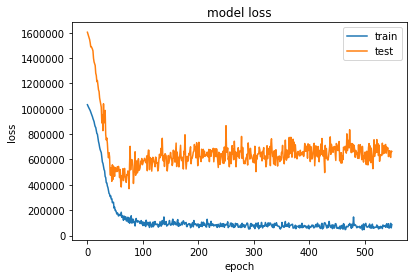

In [85]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

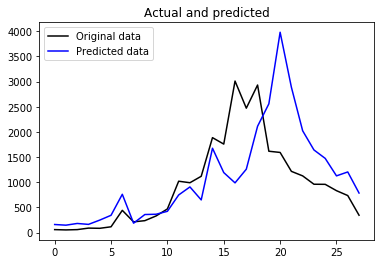

In [86]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель частично лучше повторяет структуру данных, но пики пропускает

#### модель 7, заменили relu на leaky relu, увеличили вес регуляризаций, добавили dropout

In [87]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [88]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [89]:
opt = Nadam(lr=0.001)

In [90]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [91]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 550, 
          batch_size = 15, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/550
244/244 [==============================] - 1s 6ms/step - loss: 1034896.2953 - mean_squared_error: 1034603.4889 - val_loss: 1610290.1842 - val_mean_squared_error: 1610177.3192

Epoch 00001: val_loss improved from inf to 1610290.18415, saving model to test.hdf5


C:\Pythonn\Anaconda3\lib\site-packages\keras\callbacks.py:972: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mse` which is not available. Available metrics are: val_loss,val_mean_squared_error,loss,mean_squared_error,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/550
244/244 [==============================] - 0s 305us/step - loss: 1025843.6572 - mean_squared_error: 1025475.3676 - val_loss: 1593874.1886 - val_mean_squared_error: 1593694.4855

Epoch 00002: val_loss improved from 1610290.18415 to 1593874.18862, saving model to test.hdf5
Epoch 3/550
244/244 [==============================] - 0s 215us/step - loss: 1016646.8145 - mean_squared_error: 1016117.1340 - val_loss: 1575193.8661 - val_mean_squared_error: 1574904.6618

Epoch 00003: val_loss improved from 1593874.18862 to 1575193.86607, saving model to test.hdf5
Epoch 4/550
244/244 [==============================] - 0s 224us/step - loss: 1007605.8194 - mean_squared_error: 1006946.1656 - val_loss: 1560202.1462 - val_mean_squared_error: 1559799.7969

Epoch 00004: val_loss improved from 1575193.86607 to 1560202.14621, saving model to test.hdf5
Epoch 5/550
244/244 [==============================] - 0s 230us/step - loss: 998015.8555 - mean_squared_error: 997271.9606 - val_loss: 1544154.2489 

244/244 [==============================] - 0s 285us/step - loss: 620249.7029 - mean_squared_error: 618739.4436 - val_loss: 1088399.4643 - val_mean_squared_error: 1086800.5480

Epoch 00031: val_loss did not improve from 1028248.35938
Epoch 32/550
244/244 [==============================] - 0s 281us/step - loss: 613102.9927 - mean_squared_error: 611526.9004 - val_loss: 1003107.6217 - val_mean_squared_error: 1001519.0134

Epoch 00032: val_loss improved from 1028248.35938 to 1003107.62165, saving model to test.hdf5
Epoch 33/550
244/244 [==============================] - 0s 281us/step - loss: 612096.8462 - mean_squared_error: 610413.7679 - val_loss: 905791.5324 - val_mean_squared_error: 904243.8828

Epoch 00033: val_loss improved from 1003107.62165 to 905791.53237, saving model to test.hdf5
Epoch 34/550
244/244 [==============================] - 0s 287us/step - loss: 580512.1616 - mean_squared_error: 578762.7785 - val_loss: 906643.3125 - val_mean_squared_error: 905024.4554

Epoch 00034: val_

244/244 [==============================] - 0s 293us/step - loss: 265500.1540 - mean_squared_error: 263801.2650 - val_loss: 538211.9860 - val_mean_squared_error: 536720.3019

Epoch 00063: val_loss did not improve from 485221.36663
Epoch 64/550
244/244 [==============================] - 0s 293us/step - loss: 275473.0009 - mean_squared_error: 273798.8519 - val_loss: 556433.7941 - val_mean_squared_error: 554915.3795

Epoch 00064: val_loss did not improve from 485221.36663
Epoch 65/550
244/244 [==============================] - 0s 289us/step - loss: 254303.8575 - mean_squared_error: 252768.9475 - val_loss: 532424.3225 - val_mean_squared_error: 530989.5357

Epoch 00065: val_loss did not improve from 485221.36663
Epoch 66/550
244/244 [==============================] - 0s 295us/step - loss: 245184.1438 - mean_squared_error: 243597.1829 - val_loss: 602858.2818 - val_mean_squared_error: 601354.3499

Epoch 00066: val_loss did not improve from 485221.36663
Epoch 67/550
244/244 [===================

244/244 [==============================] - 0s 299us/step - loss: 210935.7997 - mean_squared_error: 209511.4635 - val_loss: 456893.8393 - val_mean_squared_error: 455539.1657

Epoch 00096: val_loss did not improve from 407168.64425
Epoch 97/550
244/244 [==============================] - 0s 287us/step - loss: 161922.9925 - mean_squared_error: 160478.5620 - val_loss: 460298.7427 - val_mean_squared_error: 458983.2511

Epoch 00097: val_loss did not improve from 407168.64425
Epoch 98/550
244/244 [==============================] - 0s 260us/step - loss: 182612.8124 - mean_squared_error: 181149.2737 - val_loss: 463229.2980 - val_mean_squared_error: 461955.3689

Epoch 00098: val_loss did not improve from 407168.64425
Epoch 99/550
244/244 [==============================] - 0s 220us/step - loss: 180596.1861 - mean_squared_error: 179237.5589 - val_loss: 433300.4877 - val_mean_squared_error: 432103.2042

Epoch 00099: val_loss did not improve from 407168.64425
Epoch 100/550
244/244 [==================


Epoch 00129: val_loss did not improve from 407168.64425
Epoch 130/550
244/244 [==============================] - 0s 293us/step - loss: 188917.7399 - mean_squared_error: 187320.1367 - val_loss: 435453.2561 - val_mean_squared_error: 434063.8248

Epoch 00130: val_loss did not improve from 407168.64425
Epoch 131/550
244/244 [==============================] - 0s 283us/step - loss: 190984.0330 - mean_squared_error: 189300.0913 - val_loss: 478466.1110 - val_mean_squared_error: 477028.4939

Epoch 00131: val_loss did not improve from 407168.64425
Epoch 132/550
244/244 [==============================] - 0s 289us/step - loss: 162010.7247 - mean_squared_error: 160269.4673 - val_loss: 455051.5237 - val_mean_squared_error: 453614.9791

Epoch 00132: val_loss did not improve from 407168.64425
Epoch 133/550
244/244 [==============================] - 0s 222us/step - loss: 170479.2752 - mean_squared_error: 168733.6527 - val_loss: 477925.9369 - val_mean_squared_error: 476495.4425

Epoch 00133: val_loss d

244/244 [==============================] - 0s 185us/step - loss: 225227.3256 - mean_squared_error: 223736.7078 - val_loss: 465716.0921 - val_mean_squared_error: 464339.0731

Epoch 00163: val_loss did not improve from 407168.64425
Epoch 164/550
244/244 [==============================] - 0s 183us/step - loss: 179149.9057 - mean_squared_error: 177637.0626 - val_loss: 477208.9235 - val_mean_squared_error: 475843.8901

Epoch 00164: val_loss did not improve from 407168.64425
Epoch 165/550
244/244 [==============================] - 0s 211us/step - loss: 180066.9674 - mean_squared_error: 178618.7655 - val_loss: 469679.9403 - val_mean_squared_error: 468348.1674

Epoch 00165: val_loss did not improve from 407168.64425
Epoch 166/550
244/244 [==============================] - 0s 211us/step - loss: 172521.2274 - mean_squared_error: 171056.4778 - val_loss: 468028.7522 - val_mean_squared_error: 466681.9944

Epoch 00166: val_loss did not improve from 407168.64425
Epoch 167/550
244/244 [===============


Epoch 00196: val_loss did not improve from 407168.64425
Epoch 197/550
244/244 [==============================] - 0s 289us/step - loss: 166800.2654 - mean_squared_error: 165351.6299 - val_loss: 495352.0061 - val_mean_squared_error: 493994.0837

Epoch 00197: val_loss did not improve from 407168.64425
Epoch 198/550
244/244 [==============================] - 0s 228us/step - loss: 161882.7775 - mean_squared_error: 160396.5640 - val_loss: 466608.7634 - val_mean_squared_error: 465283.2271

Epoch 00198: val_loss did not improve from 407168.64425
Epoch 199/550
244/244 [==============================] - 0s 209us/step - loss: 173999.2009 - mean_squared_error: 172580.4315 - val_loss: 463521.7316 - val_mean_squared_error: 462185.0815

Epoch 00199: val_loss did not improve from 407168.64425
Epoch 200/550
244/244 [==============================] - 0s 289us/step - loss: 178680.0854 - mean_squared_error: 177223.8042 - val_loss: 435125.9461 - val_mean_squared_error: 433836.7386

Epoch 00200: val_loss d

244/244 [==============================] - 0s 226us/step - loss: 194267.0187 - mean_squared_error: 192671.2768 - val_loss: 494997.5212 - val_mean_squared_error: 493517.0731

Epoch 00230: val_loss did not improve from 407168.64425
Epoch 231/550
244/244 [==============================] - 0s 260us/step - loss: 172705.5896 - mean_squared_error: 171256.0708 - val_loss: 456159.3627 - val_mean_squared_error: 454745.7310

Epoch 00231: val_loss did not improve from 407168.64425
Epoch 232/550
244/244 [==============================] - 0s 252us/step - loss: 174242.3244 - mean_squared_error: 172771.3708 - val_loss: 472888.6244 - val_mean_squared_error: 471470.3733

Epoch 00232: val_loss did not improve from 407168.64425
Epoch 233/550
244/244 [==============================] - 0s 207us/step - loss: 151297.0210 - mean_squared_error: 149770.1530 - val_loss: 481147.6551 - val_mean_squared_error: 479732.3337

Epoch 00233: val_loss did not improve from 407168.64425
Epoch 234/550
244/244 [===============


Epoch 00263: val_loss did not improve from 407168.64425
Epoch 264/550
244/244 [==============================] - 0s 228us/step - loss: 193658.0134 - mean_squared_error: 192269.3001 - val_loss: 456509.2835 - val_mean_squared_error: 455138.6920

Epoch 00264: val_loss did not improve from 407168.64425
Epoch 265/550
244/244 [==============================] - 0s 248us/step - loss: 156999.3669 - mean_squared_error: 155619.4737 - val_loss: 468631.5737 - val_mean_squared_error: 467227.2310

Epoch 00265: val_loss did not improve from 407168.64425
Epoch 266/550
244/244 [==============================] - 0s 205us/step - loss: 153911.4407 - mean_squared_error: 152494.4789 - val_loss: 484158.1518 - val_mean_squared_error: 482734.3440

Epoch 00266: val_loss did not improve from 407168.64425
Epoch 267/550
244/244 [==============================] - 0s 236us/step - loss: 149435.1338 - mean_squared_error: 148063.5351 - val_loss: 470836.0564 - val_mean_squared_error: 469496.8287

Epoch 00267: val_loss d

244/244 [==============================] - 0s 266us/step - loss: 145286.9919 - mean_squared_error: 143893.5002 - val_loss: 483159.6250 - val_mean_squared_error: 481858.7567

Epoch 00297: val_loss did not improve from 407168.64425
Epoch 298/550
244/244 [==============================] - 0s 234us/step - loss: 165855.9615 - mean_squared_error: 164511.0182 - val_loss: 506105.5156 - val_mean_squared_error: 504807.7706

Epoch 00298: val_loss did not improve from 407168.64425
Epoch 299/550
244/244 [==============================] - 0s 215us/step - loss: 181364.4969 - mean_squared_error: 179975.8121 - val_loss: 487522.4972 - val_mean_squared_error: 486227.1222

Epoch 00299: val_loss did not improve from 407168.64425
Epoch 300/550
244/244 [==============================] - 0s 266us/step - loss: 156447.4514 - mean_squared_error: 155023.0824 - val_loss: 479189.8306 - val_mean_squared_error: 477889.9902

Epoch 00300: val_loss did not improve from 407168.64425
Epoch 301/550
244/244 [===============


Epoch 00330: val_loss did not improve from 407168.64425
Epoch 331/550
244/244 [==============================] - 0s 291us/step - loss: 142850.2198 - mean_squared_error: 141491.7262 - val_loss: 496870.0837 - val_mean_squared_error: 495562.6339

Epoch 00331: val_loss did not improve from 407168.64425
Epoch 332/550
244/244 [==============================] - 0s 272us/step - loss: 156170.9971 - mean_squared_error: 154855.4057 - val_loss: 526996.0753 - val_mean_squared_error: 525654.4369

Epoch 00332: val_loss did not improve from 407168.64425
Epoch 333/550
244/244 [==============================] - 0s 215us/step - loss: 134308.5036 - mean_squared_error: 132925.1052 - val_loss: 522501.8343 - val_mean_squared_error: 521139.2199

Epoch 00333: val_loss did not improve from 407168.64425
Epoch 334/550
244/244 [==============================] - 0s 217us/step - loss: 115251.2316 - mean_squared_error: 113859.8937 - val_loss: 521698.2695 - val_mean_squared_error: 520316.7857

Epoch 00334: val_loss d

244/244 [==============================] - 0s 333us/step - loss: 150611.8473 - mean_squared_error: 149201.7615 - val_loss: 519046.3287 - val_mean_squared_error: 517600.8231

Epoch 00364: val_loss did not improve from 407168.64425
Epoch 365/550
244/244 [==============================] - 0s 250us/step - loss: 118436.2475 - mean_squared_error: 116977.3520 - val_loss: 499133.5268 - val_mean_squared_error: 497735.7489

Epoch 00365: val_loss did not improve from 407168.64425
Epoch 366/550
244/244 [==============================] - 0s 218us/step - loss: 138954.1331 - mean_squared_error: 137440.2709 - val_loss: 513561.8516 - val_mean_squared_error: 512147.0430

Epoch 00366: val_loss did not improve from 407168.64425
Epoch 367/550
244/244 [==============================] - 0s 189us/step - loss: 161917.3154 - mean_squared_error: 160455.4498 - val_loss: 524594.1585 - val_mean_squared_error: 523157.0039

Epoch 00367: val_loss did not improve from 407168.64425
Epoch 368/550
244/244 [===============


Epoch 00397: val_loss did not improve from 407168.64425
Epoch 398/550
244/244 [==============================] - 0s 264us/step - loss: 147970.7006 - mean_squared_error: 146616.9471 - val_loss: 504220.0792 - val_mean_squared_error: 502871.4146

Epoch 00398: val_loss did not improve from 407168.64425
Epoch 399/550
244/244 [==============================] - 0s 259us/step - loss: 143746.2953 - mean_squared_error: 142319.7842 - val_loss: 526180.7740 - val_mean_squared_error: 524829.7662

Epoch 00399: val_loss did not improve from 407168.64425
Epoch 400/550
244/244 [==============================] - 0s 276us/step - loss: 178174.3878 - mean_squared_error: 176788.9687 - val_loss: 497821.8655 - val_mean_squared_error: 496475.2366

Epoch 00400: val_loss did not improve from 407168.64425
Epoch 401/550
244/244 [==============================] - 0s 289us/step - loss: 119731.6224 - mean_squared_error: 118342.5545 - val_loss: 503240.1702 - val_mean_squared_error: 501902.5960

Epoch 00401: val_loss d

244/244 [==============================] - 0s 270us/step - loss: 112194.1434 - mean_squared_error: 110815.6866 - val_loss: 511523.4908 - val_mean_squared_error: 510178.4874

Epoch 00431: val_loss did not improve from 407168.64425
Epoch 432/550
244/244 [==============================] - 0s 283us/step - loss: 162920.2124 - mean_squared_error: 161581.0734 - val_loss: 518753.5762 - val_mean_squared_error: 517417.6602

Epoch 00432: val_loss did not improve from 407168.64425
Epoch 433/550
244/244 [==============================] - 0s 285us/step - loss: 157158.0259 - mean_squared_error: 155859.8826 - val_loss: 511032.6515 - val_mean_squared_error: 509712.3223

Epoch 00433: val_loss did not improve from 407168.64425
Epoch 434/550
244/244 [==============================] - 0s 281us/step - loss: 128204.7217 - mean_squared_error: 126724.3039 - val_loss: 488537.3105 - val_mean_squared_error: 487221.5611

Epoch 00434: val_loss did not improve from 407168.64425
Epoch 435/550
244/244 [===============


Epoch 00464: val_loss did not improve from 407168.64425
Epoch 465/550
244/244 [==============================] - 0s 236us/step - loss: 181541.7410 - mean_squared_error: 180037.8750 - val_loss: 514945.8036 - val_mean_squared_error: 513558.8248

Epoch 00465: val_loss did not improve from 407168.64425
Epoch 466/550
244/244 [==============================] - 0s 211us/step - loss: 181722.5919 - mean_squared_error: 180397.2234 - val_loss: 492125.2093 - val_mean_squared_error: 490776.7603

Epoch 00466: val_loss did not improve from 407168.64425
Epoch 467/550
244/244 [==============================] - 0s 219us/step - loss: 183530.9700 - mean_squared_error: 182146.3715 - val_loss: 522647.9208 - val_mean_squared_error: 521258.3544

Epoch 00467: val_loss did not improve from 407168.64425
Epoch 468/550
244/244 [==============================] - 0s 260us/step - loss: 169752.5201 - mean_squared_error: 168346.8842 - val_loss: 506607.2589 - val_mean_squared_error: 505229.4626

Epoch 00468: val_loss d

244/244 [==============================] - 0s 220us/step - loss: 169675.0102 - mean_squared_error: 168243.9493 - val_loss: 536324.6239 - val_mean_squared_error: 534826.2360

Epoch 00498: val_loss did not improve from 407168.64425
Epoch 499/550
244/244 [==============================] - 0s 254us/step - loss: 136822.5045 - mean_squared_error: 135382.0033 - val_loss: 492196.1498 - val_mean_squared_error: 490769.5304

Epoch 00499: val_loss did not improve from 407168.64425
Epoch 500/550
244/244 [==============================] - 0s 232us/step - loss: 150089.4199 - mean_squared_error: 148639.5563 - val_loss: 460279.3549 - val_mean_squared_error: 458857.1454

Epoch 00500: val_loss did not improve from 407168.64425
Epoch 501/550
244/244 [==============================] - 0s 232us/step - loss: 153677.2274 - mean_squared_error: 152285.7917 - val_loss: 519510.0675 - val_mean_squared_error: 518030.3008

Epoch 00501: val_loss did not improve from 407168.64425
Epoch 502/550
244/244 [===============


Epoch 00531: val_loss did not improve from 407168.64425
Epoch 532/550
244/244 [==============================] - 0s 279us/step - loss: 123204.9328 - mean_squared_error: 121796.5579 - val_loss: 511961.2729 - val_mean_squared_error: 510597.5770

Epoch 00532: val_loss did not improve from 407168.64425
Epoch 533/550
244/244 [==============================] - 0s 236us/step - loss: 127182.8029 - mean_squared_error: 125754.2641 - val_loss: 509172.8931 - val_mean_squared_error: 507792.5938

Epoch 00533: val_loss did not improve from 407168.64425
Epoch 534/550
244/244 [==============================] - 0s 185us/step - loss: 161556.9826 - mean_squared_error: 160097.0510 - val_loss: 514155.3666 - val_mean_squared_error: 512774.8036

Epoch 00534: val_loss did not improve from 407168.64425
Epoch 535/550
244/244 [==============================] - 0s 187us/step - loss: 140814.5345 - mean_squared_error: 139379.9029 - val_loss: 509002.0176 - val_mean_squared_error: 507593.4551

Epoch 00535: val_loss d

#### графики

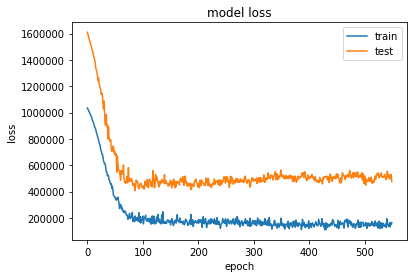

In [92]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

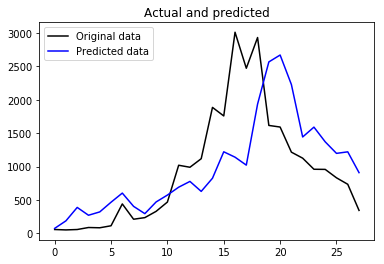

In [93]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

Модель стала работать хуже

#### модель 8, модель переобучилась, уменьшили кол-во эпох

In [94]:
model = Sequential()
model.add(Dense(164, input_dim=WINDOW,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.65))
model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [95]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_squared_error', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [96]:
opt = Nadam(lr=0.001)

In [97]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

In [98]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 350, 
          batch_size = 15, 
          verbose=2, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

C:\Pythonn\Anaconda3\lib\site-packages\keras\models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 244 samples, validate on 28 samples
Epoch 1/350
 - 2s - loss: 1033930.5174 - mean_squared_error: 1033621.3765 - val_loss: 1610131.6741 - val_mean_squared_error: 1610020.6864

Epoch 00001: val_loss improved from inf to 1610131.67411, saving model to test.hdf5
Epoch 2/350
 - 0s - loss: 1024598.2162 - mean_squared_error: 1024207.9885 - val_loss: 1591980.6116 - val_mean_squared_error: 1591807.9230

Epoch 00002: val_loss improved from 1610131.67411 to 1591980.61161, saving model to test.hdf5
Epoch 3/350
 - 0s - loss: 1015062.0510 - mean_squared_error: 1014521.3186 - val_loss: 1576137.8806 - val_mean_squared_error: 1575865.8962

Epoch 00003: val_loss improved from 1591980.61161 to 1576137.88058, saving model to test.hdf5
Epoch 4/350
 - 0s - loss: 1006985.6185 - mean_squared_error: 1006289.2515 - val_loss: 1560213.1897 - val_mean_squared_error: 1559865.9821

Epoch 00004: val_loss improved from 1576137.88058 to 1560213.18973, saving model to test.hdf5
Epoch 5/350
 - 0s - loss: 998852.


Epoch 00037: val_loss improved from 908753.21763 to 907837.28237, saving model to test.hdf5
Epoch 38/350
 - 0s - loss: 513091.2389 - mean_squared_error: 511590.0158 - val_loss: 889110.4174 - val_mean_squared_error: 887676.2757

Epoch 00038: val_loss improved from 907837.28237 to 889110.41741, saving model to test.hdf5
Epoch 39/350
 - 0s - loss: 486575.5838 - mean_squared_error: 485049.4072 - val_loss: 863434.0904 - val_mean_squared_error: 862042.7121

Epoch 00039: val_loss improved from 889110.41741 to 863434.09040, saving model to test.hdf5
Epoch 40/350
 - 0s - loss: 498036.7682 - mean_squared_error: 496617.4385 - val_loss: 798669.7154 - val_mean_squared_error: 797241.9129

Epoch 00040: val_loss improved from 863434.09040 to 798669.71540, saving model to test.hdf5
Epoch 41/350
 - 0s - loss: 467527.7062 - mean_squared_error: 466076.3117 - val_loss: 777720.0134 - val_mean_squared_error: 776266.3114

Epoch 00041: val_loss improved from 798669.71540 to 777720.01339, saving model to test.


Epoch 00077: val_loss did not improve from 439381.97042
Epoch 78/350
 - 0s - loss: 190692.4245 - mean_squared_error: 189266.6304 - val_loss: 474375.8309 - val_mean_squared_error: 473091.2550

Epoch 00078: val_loss did not improve from 439381.97042
Epoch 79/350
 - 0s - loss: 179534.5463 - mean_squared_error: 178019.7731 - val_loss: 479516.5614 - val_mean_squared_error: 478130.7439

Epoch 00079: val_loss did not improve from 439381.97042
Epoch 80/350
 - 0s - loss: 192099.9608 - mean_squared_error: 190625.6426 - val_loss: 483830.2271 - val_mean_squared_error: 482486.3309

Epoch 00080: val_loss did not improve from 439381.97042
Epoch 81/350
 - 0s - loss: 204835.0026 - mean_squared_error: 203469.9006 - val_loss: 484839.5290 - val_mean_squared_error: 483548.8382

Epoch 00081: val_loss did not improve from 439381.97042
Epoch 82/350
 - 0s - loss: 175098.1479 - mean_squared_error: 173756.6388 - val_loss: 500302.0692 - val_mean_squared_error: 499012.7360

Epoch 00082: val_loss did not improve f


Epoch 00120: val_loss did not improve from 404712.37277
Epoch 121/350
 - 0s - loss: 182115.0612 - mean_squared_error: 180747.0457 - val_loss: 473671.9570 - val_mean_squared_error: 472508.5033

Epoch 00121: val_loss did not improve from 404712.37277
Epoch 122/350
 - 0s - loss: 191647.4671 - mean_squared_error: 190271.9514 - val_loss: 502412.3493 - val_mean_squared_error: 501270.5435

Epoch 00122: val_loss did not improve from 404712.37277
Epoch 123/350
 - 0s - loss: 163722.5497 - mean_squared_error: 162421.4252 - val_loss: 511176.8493 - val_mean_squared_error: 510051.3265

Epoch 00123: val_loss did not improve from 404712.37277
Epoch 124/350
 - 0s - loss: 163011.8653 - mean_squared_error: 161747.7932 - val_loss: 458517.8527 - val_mean_squared_error: 457465.5798

Epoch 00124: val_loss did not improve from 404712.37277
Epoch 125/350
 - 0s - loss: 187182.8714 - mean_squared_error: 185886.1127 - val_loss: 511746.0619 - val_mean_squared_error: 510540.4224

Epoch 00125: val_loss did not impr

 - 0s - loss: 179803.5110 - mean_squared_error: 178407.1945 - val_loss: 435275.6853 - val_mean_squared_error: 433951.6239

Epoch 00163: val_loss did not improve from 404712.37277
Epoch 164/350
 - 0s - loss: 163589.0475 - mean_squared_error: 162143.2698 - val_loss: 427943.8694 - val_mean_squared_error: 426641.1113

Epoch 00164: val_loss did not improve from 404712.37277
Epoch 165/350
 - 0s - loss: 171001.5623 - mean_squared_error: 169624.2931 - val_loss: 467395.6116 - val_mean_squared_error: 466088.7204

Epoch 00165: val_loss did not improve from 404712.37277
Epoch 166/350
 - 0s - loss: 164841.5908 - mean_squared_error: 163463.7242 - val_loss: 471766.3544 - val_mean_squared_error: 470480.6903

Epoch 00166: val_loss did not improve from 404712.37277
Epoch 167/350
 - 0s - loss: 189103.5626 - mean_squared_error: 187773.0537 - val_loss: 462437.1847 - val_mean_squared_error: 461160.0675

Epoch 00167: val_loss did not improve from 404712.37277
Epoch 168/350
 - 0s - loss: 156364.5863 - mean_sq


Epoch 00205: val_loss did not improve from 404712.37277
Epoch 206/350
 - 0s - loss: 156968.9931 - mean_squared_error: 155552.6117 - val_loss: 428903.0346 - val_mean_squared_error: 427726.3298

Epoch 00206: val_loss did not improve from 404712.37277
Epoch 207/350
 - 0s - loss: 179042.0098 - mean_squared_error: 177699.8595 - val_loss: 465024.2171 - val_mean_squared_error: 463843.5050

Epoch 00207: val_loss did not improve from 404712.37277
Epoch 208/350
 - 0s - loss: 129664.5051 - mean_squared_error: 128293.3595 - val_loss: 470501.0915 - val_mean_squared_error: 469336.0184

Epoch 00208: val_loss did not improve from 404712.37277
Epoch 209/350
 - 0s - loss: 168514.1308 - mean_squared_error: 167140.4792 - val_loss: 457753.4699 - val_mean_squared_error: 456610.7863

Epoch 00209: val_loss did not improve from 404712.37277
Epoch 210/350
 - 0s - loss: 183741.1407 - mean_squared_error: 182374.1696 - val_loss: 480783.3371 - val_mean_squared_error: 479617.3304

Epoch 00210: val_loss did not impr


Epoch 00248: val_loss did not improve from 404712.37277
Epoch 249/350
 - 0s - loss: 168507.8241 - mean_squared_error: 167158.5405 - val_loss: 502937.9213 - val_mean_squared_error: 501735.4235

Epoch 00249: val_loss did not improve from 404712.37277
Epoch 250/350
 - 0s - loss: 138030.0889 - mean_squared_error: 136663.8553 - val_loss: 476221.3382 - val_mean_squared_error: 475051.3867

Epoch 00250: val_loss did not improve from 404712.37277
Epoch 251/350
 - 0s - loss: 156430.5296 - mean_squared_error: 155092.9713 - val_loss: 473196.8365 - val_mean_squared_error: 472032.0586

Epoch 00251: val_loss did not improve from 404712.37277
Epoch 252/350
 - 0s - loss: 157180.5033 - mean_squared_error: 155852.7125 - val_loss: 472466.1886 - val_mean_squared_error: 471303.1317

Epoch 00252: val_loss did not improve from 404712.37277
Epoch 253/350
 - 0s - loss: 144234.7746 - mean_squared_error: 142960.4720 - val_loss: 478942.9124 - val_mean_squared_error: 477794.9230

Epoch 00253: val_loss did not impr

 - 0s - loss: 156402.5402 - mean_squared_error: 155165.5028 - val_loss: 491187.0826 - val_mean_squared_error: 490034.7866

Epoch 00291: val_loss did not improve from 404712.37277
Epoch 292/350
 - 0s - loss: 162910.4678 - mean_squared_error: 161669.8018 - val_loss: 480998.3599 - val_mean_squared_error: 479850.4994

Epoch 00292: val_loss did not improve from 404712.37277
Epoch 293/350
 - 0s - loss: 143775.1890 - mean_squared_error: 142571.9833 - val_loss: 487058.9972 - val_mean_squared_error: 485902.6917

Epoch 00293: val_loss did not improve from 404712.37277
Epoch 294/350
 - 0s - loss: 176449.6869 - mean_squared_error: 175293.9399 - val_loss: 465647.3672 - val_mean_squared_error: 464544.4810

Epoch 00294: val_loss did not improve from 404712.37277
Epoch 295/350
 - 0s - loss: 157760.6102 - mean_squared_error: 156573.2164 - val_loss: 437583.8407 - val_mean_squared_error: 436498.4339

Epoch 00295: val_loss did not improve from 404712.37277
Epoch 296/350
 - 0s - loss: 146189.1643 - mean_sq


Epoch 00333: val_loss did not improve from 404712.37277
Epoch 334/350
 - 0s - loss: 154129.5673 - mean_squared_error: 152782.4827 - val_loss: 478496.1088 - val_mean_squared_error: 477329.4068

Epoch 00334: val_loss did not improve from 404712.37277
Epoch 335/350
 - 0s - loss: 178675.4903 - mean_squared_error: 177390.1085 - val_loss: 489240.1819 - val_mean_squared_error: 488059.8795

Epoch 00335: val_loss did not improve from 404712.37277
Epoch 336/350
 - 0s - loss: 163083.8361 - mean_squared_error: 161777.0009 - val_loss: 463537.8465 - val_mean_squared_error: 462374.8482

Epoch 00336: val_loss did not improve from 404712.37277
Epoch 337/350
 - 0s - loss: 163546.5820 - mean_squared_error: 162255.7054 - val_loss: 482443.9353 - val_mean_squared_error: 481273.0580

Epoch 00337: val_loss did not improve from 404712.37277
Epoch 338/350
 - 0s - loss: 118887.8079 - mean_squared_error: 117522.8734 - val_loss: 492073.2400 - val_mean_squared_error: 490908.3979

Epoch 00338: val_loss did not impr

#### графики

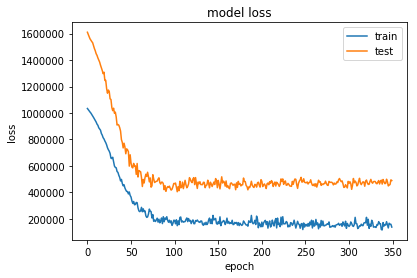

In [99]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

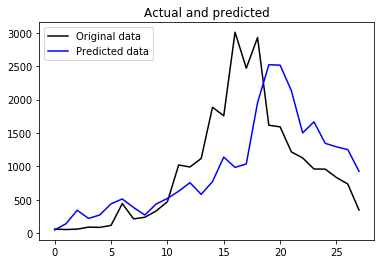

In [100]:
pred = model.predict(np.array(X_test))
original = Y_test
predicted = pred

plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()

### Вывод

1. классические функции активации (sigmoid, tanh) не работают вовсе - relu, leaky relu существенно лучше
2. добавление dropout, batchnormalization помогло увеличить общую точность, но пик продаж модель так и не схватывает
Ошибка получается существенно выше, чем при использовании классических методов анализа временных рядов

Перейдем к альтернативному способу использовани нейронной сети

## Нейронная сеть, альтернативное использование

### импорты

In [101]:
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score
from math import sqrt

Использовали несколько разных функций для проверки ошибок

In [102]:
import copy

In [103]:
df.head()

,data,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


In [113]:
data2 = copy.deepcopy(df)

In [114]:
del data2['forecast']

### вывод таблицы

In [115]:
data2.head()

,data,sales
2012-09-09,09.09.2012,25
2012-09-16,16.09.2012,12
2012-09-23,23.09.2012,11
2012-09-30,30.09.2012,5
2012-10-07,07.10.2012,4


In [116]:
data2.columns = ['dates','sales']

### написание функций

In [117]:
def CV(X_train, Y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = Y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) 

        index = int(np.floor(X.shape[0] * split))
    
        X_trainFolds = X[:index]        
        Y_trainFolds = y[:index]

        X_testFold = X[(index + 1):]
        Y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, Y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), Y_testFold)
   
    return errors.mean()

In [209]:
def rmse(ytrue,ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred));
def mse(ytrue,ypred):
    return (mean_squared_error(ytrue, ypred));
def rmsle(ytrue, ypred):
    return mean_squared_log_error(ytrue, ypred);
def mae (ytrue,ypred):
    return mean_absolute_error(ytrue,ypred);
def r2 (ytrue,ypred):
    return r2_score(ytrue,ypred);
def evs (ytrue,ypred):
    return explained_variance_score(ytrue,ypred);
def medae (ytrue,ypred):
    return median_absolute_error(ytrue,ypred)



In [214]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

### подготовка данных

In [119]:
start = datetime.datetime.strptime("2012-09-09", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,len(data2.sales))]
data2['index'] =date_list
data2.set_index(['index'], inplace=True)
data2.index.name=None

In [120]:
data2.dates = pd.to_datetime(data2.dates)
data2.TRDATETIME = pd.to_datetime(data2['dates'],  dayfirst= True, format='%d%b%y:%H:%M:%S')

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [121]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 309 entries, 2012-09-09 to 2018-08-05
Data columns (total 2 columns):
dates    309 non-null datetime64[ns]
sales    309 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 7.2 KB


In [122]:
data2['date'] = data2['dates'].dt.date
data2['day'] = data2['dates'].dt.day
data2['month'] = data2['dates'].dt.month
data2['year'] = data2['dates'].dt.year

In [123]:
data2.head()

,dates,sales,date,day,month,year
2012-09-09,2012-09-09,25,2012-09-09,9,9,2012
2012-09-16,2012-09-16,12,2012-09-16,16,9,2012
2012-09-23,2012-09-23,11,2012-09-23,23,9,2012
2012-09-30,2012-09-30,5,2012-09-30,30,9,2012
2012-10-07,2012-07-10,4,2012-07-10,10,7,2012


In [124]:
data2['season'] = data2.sales

In [125]:
data2['season'].loc['2012':'2013-03-01'] = "aw"
data2['season'].loc['2013-03-01':'2013-09-01'] = "ss"
data2['season'].loc['2013-09-01':'2014-03-01'] = "aw"
data2['season'].loc['2014-03-01':'2014-09-01'] = "ss"
data2['season'].loc['2014-09-01':'2015-03-01'] = "aw"
data2['season'].loc['2015-03-01':'2015-09-01'] = "ss"
data2['season'].loc['2015-09-01':'2016-03-01'] = "aw"
data2['season'].loc['2016-03-01':'2016-09-01'] = "ss"
data2['season'].loc['2016-09-01':'2017-03-01'] = "aw"
data2['season'].loc['2017-03-01':'2017-09-01'] = "ss"
data2['season'].loc['2017-09-01':'2018-03-01'] = "aw"
data2['season'].loc['2018-03-01':'2018-09-01'] = "ss"

C:\Pythonn\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [126]:
data2['Last_Week_Sales'] = data2['sales'].shift()
data2['Last_Week_Diff'] = data2['Last_Week_Sales'].diff()
data2 = data2.dropna()

In [127]:
data2.head()

,dates,sales,date,day,month,year,season,Last_Week_Sales,Last_Week_Diff
2012-09-23,2012-09-23,11,2012-09-23,23,9,2012,aw,12.0,-13.0
2012-09-30,2012-09-30,5,2012-09-30,30,9,2012,aw,11.0,-1.0
2012-10-07,2012-07-10,4,2012-07-10,10,7,2012,aw,5.0,-6.0
2012-10-14,2012-10-14,6,2012-10-14,14,10,2012,aw,4.0,-1.0
2012-10-21,2012-10-21,2,2012-10-21,21,10,2012,aw,6.0,2.0


In [128]:
data2['weeks'] = list(range(len(data2.index)))

In [129]:
data2.index = list(range(len(data2.index)))

In [130]:
data2.drop('dates', axis = 1, inplace = True)

In [131]:
data2.drop('date', axis = 1, inplace = True)

In [132]:
data2.head()

,sales,day,month,year,season,Last_Week_Sales,Last_Week_Diff,weeks
0,11,23,9,2012,aw,12.0,-13.0,0
1,5,30,9,2012,aw,11.0,-1.0,1
2,4,10,7,2012,aw,5.0,-6.0,2
3,6,14,10,2012,aw,4.0,-1.0,3
4,2,21,10,2012,aw,6.0,2.0,4


In [133]:
data3 = pd.get_dummies(data2)

In [134]:
data3.head()

,sales,day,month,year,Last_Week_Sales,Last_Week_Diff,weeks,season_aw,season_ss
0,11,23,9,2012,12.0,-13.0,0,1,0
1,5,30,9,2012,11.0,-1.0,1,1,0
2,4,10,7,2012,5.0,-6.0,2,1,0
3,6,14,10,2012,4.0,-1.0,3,1,0
4,2,21,10,2012,6.0,2.0,4,1,0


In [135]:
Y = data3.sales

In [136]:
X = data3.drop('sales', axis = 1)

In [279]:
X_train = data3[:296].drop('sales', axis = 1)
Y_train = data3[:296].sales

In [280]:
X_test = data3[296:].drop('sales', axis = 1)
Y_test = data3[296:].sales

### Итоговая модель из 3.2

In [281]:
model = Sequential()
model.add(Dense(64, input_dim=8,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(360,
                activity_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))

In [282]:
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

In [283]:
opt = Nadam(lr=0.01)

In [284]:
model.compile(optimizer=opt, 
              loss='mse',
              metrics=['mse'])

### Прогон модели через функцию performCV

In [285]:
CV(X_train, Y_train, 100, model, rmse)

Size train set: (296, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)
Epoch 1/1
2/2 [==============================] - 1s 535ms/step - loss: 628390.4375 - mean_squared_error: 75.2209

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)
Epoch 1/1
4/4 [==============================] - 0s 620us/step - loss: 1110815.7500 - mean_squared_error: 32.6832

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)
Epoch 1/1
6/6 [==============================] - 0s 414us/step - loss: 1487036.1250 - mean_squared_error: 19.7432

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)
Epoch 1/1
8/8 [==============================] - 0s 308us/step - loss: 1764874.7500 - mean_squared_error: 19.4442

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)
Epoch 1/1
10/10 [==============================] - 0s 245us/step - loss: 1951345.3750 - mean_squared_error: 9.2577

Splitting the first 7 chunks at 6/7
Size of train +

88/88 [==============================] - 0s 107us/step - loss: 168936.9943 - mean_squared_error: 154357.7912

Splitting the first 46 chunks at 45/46
Size of train + test: (92, 8)
Epoch 1/1
90/90 [==============================] - 0s 94us/step - loss: 201843.8514 - mean_squared_error: 183350.0035

Splitting the first 47 chunks at 46/47
Size of train + test: (94, 8)
Epoch 1/1
92/92 [==============================] - 0s 86us/step - loss: 223481.8587 - mean_squared_error: 202400.6299

Splitting the first 48 chunks at 47/48
Size of train + test: (96, 8)
Epoch 1/1
94/94 [==============================] - 0s 95us/step - loss: 197957.8464 - mean_squared_error: 180047.6825

Splitting the first 49 chunks at 48/49
Size of train + test: (98, 8)
Epoch 1/1
96/96 [==============================] - 0s 93us/step - loss: 229235.8516 - mean_squared_error: 198741.5625

Splitting the first 50 chunks at 49/50
Size of train + test: (100, 8)
Epoch 1/1
98/98 [==============================] - 0s 106us/step - l

174/174 [==============================] - 0s 83us/step - loss: 100395.8504 - mean_squared_error: 76229.6778

Splitting the first 89 chunks at 88/89
Size of train + test: (178, 8)
Epoch 1/1
176/176 [==============================] - 0s 90us/step - loss: 91657.5291 - mean_squared_error: 71391.6378

Splitting the first 90 chunks at 89/90
Size of train + test: (180, 8)
Epoch 1/1
178/178 [==============================] - 0s 81us/step - loss: 92757.3635 - mean_squared_error: 77019.3249

Splitting the first 91 chunks at 90/91
Size of train + test: (182, 8)
Epoch 1/1
180/180 [==============================] - 0s 80us/step - loss: 81847.9928 - mean_squared_error: 68339.2024

Splitting the first 92 chunks at 91/92
Size of train + test: (184, 8)
Epoch 1/1
182/182 [==============================] - 0s 84us/step - loss: 136186.4070 - mean_squared_error: 123793.4642

Splitting the first 93 chunks at 92/93
Size of train + test: (186, 8)
Epoch 1/1
184/184 [==============================] - 0s 78us/s

318.0118609913672

### Прогноз

In [322]:
nnpr = model.predict(X_test)

In [323]:
df.forecast[297] = nnpr[0]
df.forecast[298] = nnpr[1]
df.forecast[299] = nnpr[2]
df.forecast[300] = nnpr[3]
df.forecast[301] = nnpr[4]
df.forecast[302] = nnpr[5]
df.forecast[303] = nnpr[6]
df.forecast[304] = nnpr[7]
df.forecast[305] = nnpr[8]
df.forecast[306] = nnpr[9]
df.forecast[307] = nnpr[10]

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Pythonn\Anaconda3\lib\site-p

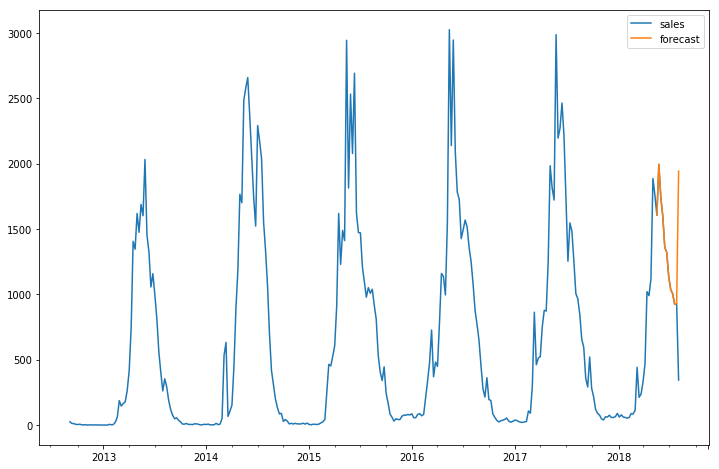

In [324]:

df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [286]:
mape(Y_test, model.predict(X_test))

0.6441354327295642

### Вывод

Подход с кроссвалидацией нейронных сетей помог существенно снизить ошибку, но не перебить методы классического анализа временных рядов

## Классические методы ML

В классических методах ML будем использовать аналогичный 3.3 способ

### импорты

In [264]:
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [265]:
from xgboost import XGBRegressor

### RFR

In [266]:
mdl = RandomForestRegressor(n_estimators=1000, criterion='mse',n_jobs=-1)

In [267]:
CV(X_train, Y_train, 100, mdl, rmse)

Size train set: (298, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

179.93655555555557

#### Предсказание

In [268]:
rfrpred = mdl.predict(X_test)

In [325]:
df.forecast[297] = rfrpred[0]
df.forecast[298] = rfrpred[1]
df.forecast[299] = rfrpred[2]
df.forecast[300] = rfrpred[3]
df.forecast[301] = rfrpred[4]
df.forecast[302] = rfrpred[5]
df.forecast[303] = rfrpred[6]
df.forecast[304] = rfrpred[7]
df.forecast[305] = rfrpred[8]
df.forecast[306] = rfrpred[9]
df.forecast[307] = rfrpred[10]

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Pythonn\Anaconda3\lib\site-p

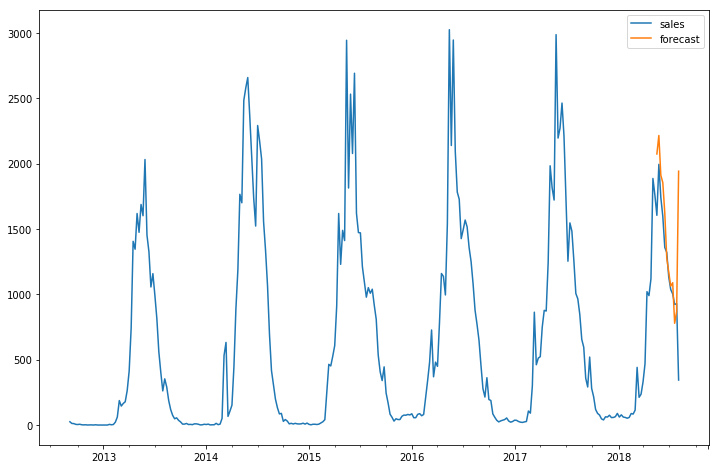

In [326]:

df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [269]:
mape(Y_test, rfrpred )

0.3124562546268827

### XGBR

In [270]:
mdl1 = XGBRegressor(learning_rate=0.01, n_estimators=10000, booster='gblinear' )

In [271]:
CV(X_train, Y_train, 110, mdl1, rmse)

Size train set: (298, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

151.8792785356898

#### Предсказание

In [272]:
XGBRpred = mdl1.predict(X_test)

In [328]:
df.forecast[297] = XGBRpred[0]
df.forecast[298] = XGBRpred[1]
df.forecast[299] = XGBRpred[2]
df.forecast[300] = XGBRpred[3]
df.forecast[301] = XGBRpred[4]
df.forecast[302] = XGBRpred[5]
df.forecast[303] = XGBRpred[6]
df.forecast[304] = XGBRpred[7]
df.forecast[305] = XGBRpred[8]
df.forecast[306] = XGBRpred[9]
df.forecast[307] = XGBRpred[10]

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Pythonn\Anaconda3\lib\site-p

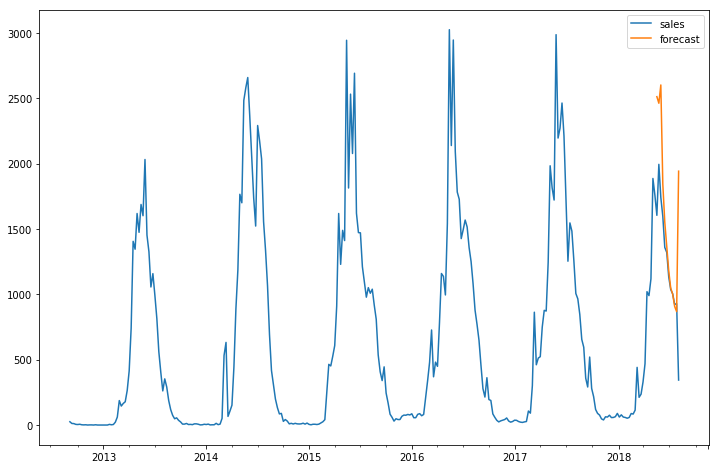

In [329]:

df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [273]:
mape(Y_test, XGBRpred )

0.3377739377908288

### LinReg

In [274]:
import sklearn.linear_model as lm

In [275]:
mdl2 = lm.LinearRegression(normalize=False)

In [276]:
CV(X_train, Y_train, 130, mdl2, rmse)

Size train set: (298, 8)
Size of each fold: 2

Splitting the first 2 chunks at 1/2
Size of train + test: (4, 8)

Splitting the first 3 chunks at 2/3
Size of train + test: (6, 8)

Splitting the first 4 chunks at 3/4
Size of train + test: (8, 8)

Splitting the first 5 chunks at 4/5
Size of train + test: (10, 8)

Splitting the first 6 chunks at 5/6
Size of train + test: (12, 8)

Splitting the first 7 chunks at 6/7
Size of train + test: (14, 8)

Splitting the first 8 chunks at 7/8
Size of train + test: (16, 8)

Splitting the first 9 chunks at 8/9
Size of train + test: (18, 8)

Splitting the first 10 chunks at 9/10
Size of train + test: (20, 8)

Splitting the first 11 chunks at 10/11
Size of train + test: (22, 8)

Splitting the first 12 chunks at 11/12
Size of train + test: (24, 8)

Splitting the first 13 chunks at 12/13
Size of train + test: (26, 8)

Splitting the first 14 chunks at 13/14
Size of train + test: (28, 8)

Splitting the first 15 chunks at 14/15
Size of train + test: (30, 8)

S

163.5005000939232

#### Предсказание

In [277]:
lrpred = mdl2.predict(X_test)

In [330]:
df.forecast[297] = lrpred[0]
df.forecast[298] = lrpred[1]
df.forecast[299] = lrpred[2]
df.forecast[300] = lrpred[3]
df.forecast[301] = lrpred[4]
df.forecast[302] = lrpred[5]
df.forecast[303] = lrpred[6]
df.forecast[304] = lrpred[7]
df.forecast[305] = lrpred[8]
df.forecast[306] = lrpred[9]
df.forecast[307] = lrpred[10]

C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Pythonn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Pythonn\Anaconda3\lib\site-p

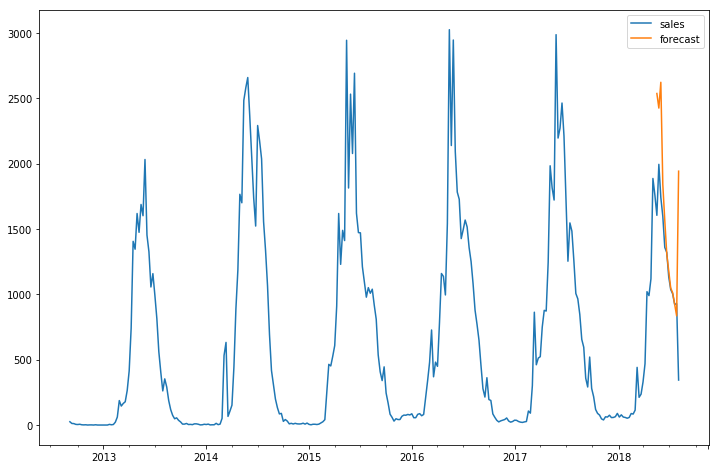

In [331]:

df[['sales', 'forecast']].plot(figsize=(12, 8))
# plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [278]:
mape(Y_test, lrpred )

0.33188879454052506

### Вывод

все модели, "прогоняемые" через кросс-валидацию, показали гораздо более высокую точность по сравнению с другими алгоритмами

# Результаты

## Оценка и валидация модели: привести значения метрик
качества для итоговой модели, подтвердить робастность
модели (надежности и устойчивости к шумам, выбросам и
ошибочным данным). Если есть общедоступные, похожие
решения, сравнить свою модель с ними.

1. SARIMA MAPE = 144%
2. Keras classic MAPE  = >>1000
3. Keras alt MAPE = 64%
4. RFR MAPE = 30.7%
5. XGBR MAPE = 33.8%
6. LR MAPE = 33.2%

Как видно из расчетов, в условиях недостаточности данных (309 значений), нейронные сети в нескольких вариантах существенно хуже справляются с задачей, чем ski-kit learn и классические методы анализа временных рядов

## Внедрение, подтверждение результата (если применимо):

Обосновать работоспособность и необходимость введения такой практики продаж еще предстоит

# Выводы и заключение

## Перечисление выводов: решена ли исходная задача,

Проделанную работу нельзя считать готовым решением задачи прогнозирования, но можно считать как baseline для продолжения расчетов.
показатель в 70%, в целом, можно считать достаточным для обоснования выделения ресурсов руководством.
Налицо нехватка данных: неизвестно количество магазинов, регионы, погода, продажи компании в целом, наличие клубных карт и т.д.



## Дальнейшее развитие: 

Проделанная работа является первой частью основной задачи - оценки внедрения динамического ценообразования в компании (по аналогии с авиабилетами).
Предварительные расчеты в excel показали возможность извлечения дополнительной прибыли за счет:
уменьшения стоимости хранения за счет увеличения продаж
увеличения прибыли также за счет увеличения продаж


# Список источников.

1. www.habr.ru
2. www.stackoverflow.com
3. методические материалы с курса
4. www.medium.com
5. Прикладное машинное обучение с skikit-learn и Tensorflow. изд. O`Riely, 2018
